<a href="https://colab.research.google.com/github/fairyizzy/analgesic_toxicity/blob/main/ANALYSIS_REGRESSION_CLASSIFICATION_FPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#MOUNT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#SET DIRECTORY
import os

os.chdir("drive/MyDrive/Colab Notebooks/AITIS/Combined_Datasets_Year-By-Year/")
os.listdir()

['master_dataset_A_Lowercase.csv',
 'master_dataset_B_Lowercase.csv',
 'master_dataset_D_Lowercase.csv',
 'master_dataset_E_Lowercase.csv',
 'master_dataset_F_Lowercase.csv',
 'master_dataset_G_Lowercase.csv',
 'master_dataset_H_Lowercase.csv',
 'master_dataset_I_Lowercase.csv',
 'master_dataset_J_Lowercase.csv',
 'master_dataset_C_Lowercase.csv',
 'master_merged.csv',
 'WRANGLED_master_merged.csv',
 'master_merged_2.csv',
 'master_merged_+_homa-ir.csv',
 'master_merged_+_homa-ir_3.csv',
 'WRANGLED_master_merged_+_homa-ir_3.csv',
 'columns_1_to_30.csv',
 'normalised_master_ds_+_homa-ir_-_under_18.csv',
 'normalised_master_ds_+_homa-ir_-_under_18_-_33.33.csv',
 'normalised_master_ds_+_homa-ir_-_under_18_-_33.33_0.csv',
 'normalised_master_ds_+_homa-ir_-_under_18_-_33.33_0_Z.csv',
 'THE_FINAL_MASTER_DATASET(-18,-XHOMA,-33.3,-60%_0).csv',
 'normalised_master_ds_+_homa-ir_-_under_16.csv',
 'normalised_master_ds_+_homa-ir_-_under_16_-_33.33_0_Z.csv',
 'plots',
 'THE_FINAL_MASTER_DATASET(-16

In [ ]:
#=================================================================
# UTILITY FUNCTIONS
#=================================================================

import numpy as np

def model_evaluation(y, y_hat, n_features=df.shape[1]):

    # Convert y and y_hat to 1D arrays
    try:
      y = y.iloc[:, 0].values
      y_hat = y_hat.iloc[:, 0].values
    except:
      print("ERROR: type(y): " + type(y))
      print("ERROR: type(y_hat): " + type(y_hat))

    # Ensure y and y_hat are of the same shape
    if y.shape != y_hat.shape:
        raise ValueError("y and y_hat must have the same shape.")

    # Convert y to numpy array for calculations
    residuals = y - y_hat

    # Calculate metrics
    mae = mean_absolute_error(y, y_hat)
    mse = mean_squared_error(y, y_hat)
    rmse = mean_squared_error(y, y_hat, squared=False)
    r2 = r2_score(y, y_hat)
    n = len(y)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    dw = durbin_watson(residuals)
    shapiro_stat, shapiro_p = shapiro(residuals)

    # Scatter plot of residuals
    plt.figure(figsize=(10,5))

    # First subplot: Residual Plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_hat, residuals)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title("Residual Plot")
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")

    # Second subplot: y vs y_hat with interpolation line
    plt.subplot(1, 2, 2)
    plt.scatter(y, y_hat, alpha=0.5)

    # Calculate the linear regression line
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(y.reshape(-1, 1), y_hat)
    y_lr = lr.predict(y.reshape(-1, 1))

    # Plot the linear regression line
    plt.plot(y, y_lr, 'r--', lw=2)

    plt.title("Actual vs Predicted")
    plt.xlabel("Actual values")
    plt.ylabel("Predicted values")

    plt.tight_layout()
    plt.show()

    # AIC & BIC (using a workaround)
    residuals_std = np.std(residuals)
    log_likelihood = -n/2 * (1 + np.log(2 * np.pi)) - n/2 * np.log(residuals_std**2)
    aic = -2 * log_likelihood + 2 * n_features
    bic = -2 * log_likelihood + n_features * np.log(n)

    # Create a summary table with formatted metrics
    metrics = {
        "Mean Absolute Error (MAE)": "{:.4f}".format(mae),
        "Mean Squared Error (MSE)": "{:.4f}".format(mse),
        "Root Mean Squared Error (RMSE)": "{:.4f}".format(rmse),
        "R-squared": "{:.4f}".format(r2),
        "Adjusted R-squared": "{:.4f}".format(adj_r2),
        "Durbin-Watson": "{:.4f}".format(dw),
        "Shapiro-Wilk Statistic": "{:.4f}".format(shapiro_stat),
        "Shapiro-Wilk p-value": "{:.4f}".format(shapiro_p),
        "AIC": "{:.4f}".format(aic),
        "BIC": "{:.4f}".format(bic)
    }

    summary_table = pd.DataFrame(metrics, index=["Value"]).transpose()

    return summary_table




def preprocess(X, y, winz: bool = True, norm_type:int = 2, imputer_type: int=1):

    # Initial split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if winz:
      # winsorize, get rid of extremes
      upper_cut = y_train.quantile(0.95)
      lower_cut = y_train.quantile(0.05)
      mask_keep = (y_train <= upper_cut) & (y_train >= lower_cut)
      X_train = X_train[mask_keep.values]
      y_train = y_train[mask_keep.values]

    if norm_type == 1:
      # Step 1: Scaling the features
      scaler = StandardScaler()
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)

      # Reshape and scale y_train and y_test
      y_train = y_train.values
      y_test = y_test.values
    # Different tests to run,,,,
    elif norm_type == 2:
      # Step 1: Scaling the features
      scaler = StandardScaler()
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)

      # log the y vals ... R2=0!
      y_train = np.log(y_train.values)
      y_test = np.log(y_test.values)

    # Impute missing values
    if imputer_type == 1:
      imputer = SimpleImputer(strategy='median')
      X_train = imputer.fit_transform(X_train)
      X_test = imputer.transform(X_test)

    return X_train, y_train, X_test, y_test

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
def stepwise_regression(X_train, y_train, X_test, y_test, k_max: int = -1):
    num_features = X_train.shape[1]
    best_r2 = -1
    best_model = None
    selected_features = []

    for _ in range(num_features):
        remaining_features = [f for f in range(num_features) if f not in selected_features]
        candidate_r2 = []

        for feature in remaining_features:
            model_features = selected_features + [feature]
            X_train_subset = X_train[:, model_features]

            # Create and fit a Linear Regression model
            model = LinearRegression()
            model.fit(X_train_subset, y_train)

            # Calculate R-squared for the model
            y_hat = model.predict(X_train_subset)
            r2 = r2_score(y_train, y_hat)
            candidate_r2.append((r2, feature))

        candidate_r2.sort(reverse=True)
        best_candidate_r2, best_candidate_feature = candidate_r2[0]

        if best_candidate_r2 > best_r2:
            best_r2 = best_candidate_r2
            selected_features.append(best_candidate_feature)

            X_train_selected = X_train[:, selected_features]
            best_model = LinearRegression()
            best_model.fit(X_train_selected, y_train)
            best_selected_features = selected_features

            # Create and fit the final Linear Regression model with the selected features
            X_test_selected = X_test[:, best_selected_features]
            y_hat = best_model.predict(X_test_selected)
            r2 = r2_score(y_test, y_hat)
            print("TEST R2: {:.4f}; Feature: {}".format(r2, best_selected_features))

            if (k_max != -1) & (len(selected_features) >= k_max):
              break
        else:
            break

    return best_model, best_selected_features

def predict_with_selected_model(X_test, model):
    #X_test = sm.add_constant(X_test)  # Add the constant term
    y_hat = model.predict(X_test)
    return y_hat

Regression Approach

TEST R2: 0.2631; Feature: [63]
TEST R2: 0.2996; Feature: [63, 120]
TEST R2: 0.3481; Feature: [63, 120, 34]
TEST R2: 0.3626; Feature: [63, 120, 34, 43]
TEST R2: 0.3770; Feature: [63, 120, 34, 43, 104]
TEST R2: 0.3876; Feature: [63, 120, 34, 43, 104, 58]
TEST R2: 0.3980; Feature: [63, 120, 34, 43, 104, 58, 30]
TEST R2: 0.4016; Feature: [63, 120, 34, 43, 104, 58, 30, 136]
TEST R2: 0.4065; Feature: [63, 120, 34, 43, 104, 58, 30, 136, 180]
TEST R2: 0.4087; Feature: [63, 120, 34, 43, 104, 58, 30, 136, 180, 66]
LinearRegression()
y_test_df.shape:(5436, 1)
y_hat_df.shape:(5436, 1)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


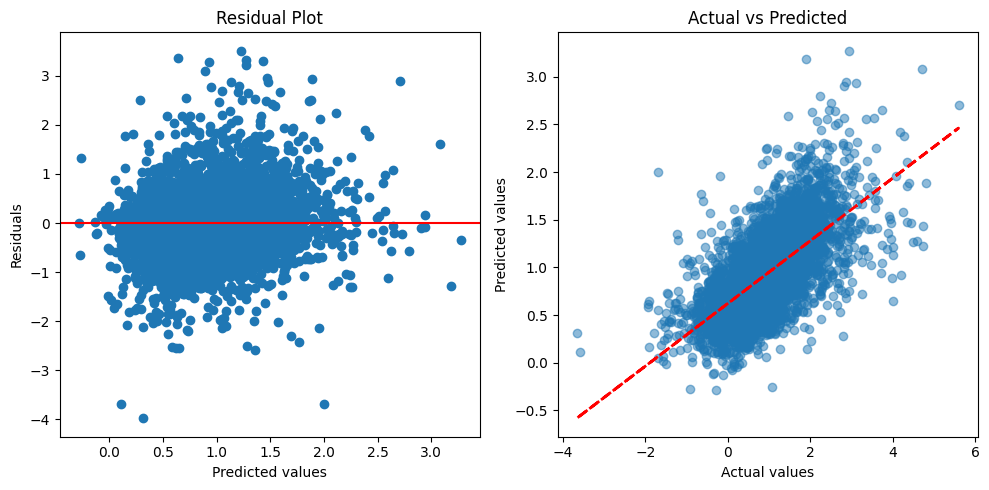

                                     Value
Mean Absolute Error (MAE)           0.4765
Mean Squared Error (MSE)            0.4172
Root Mean Squared Error (RMSE)      0.6459
R-squared                           0.4087
Adjusted R-squared                  0.3880
Durbin-Watson                       2.0191
Shapiro-Wilk Statistic              0.9696
Shapiro-Wilk p-value                0.0000
AIC                             11040.5693
BIC                             12255.1162
RandomForestRegressor
y_test_df.shape:(5436, 1)
y_hat_df.shape:(5436, 1)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


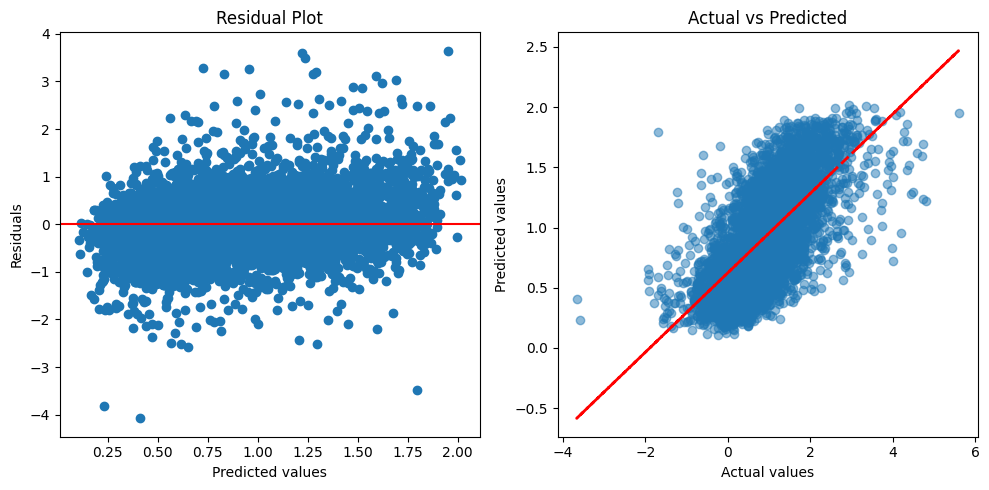

                                     Value
Mean Absolute Error (MAE)           0.4686
Mean Squared Error (MSE)            0.4074
Root Mean Squared Error (RMSE)      0.6383
R-squared                           0.4225
Adjusted R-squared                  0.4023
Durbin-Watson                       2.0150
Shapiro-Wilk Statistic              0.9660
Shapiro-Wilk p-value                0.0000
AIC                             10912.5467
BIC                             12127.0937
XGBRegressor
y_test_df.shape:(5436, 1)
y_hat_df.shape:(5436, 1)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


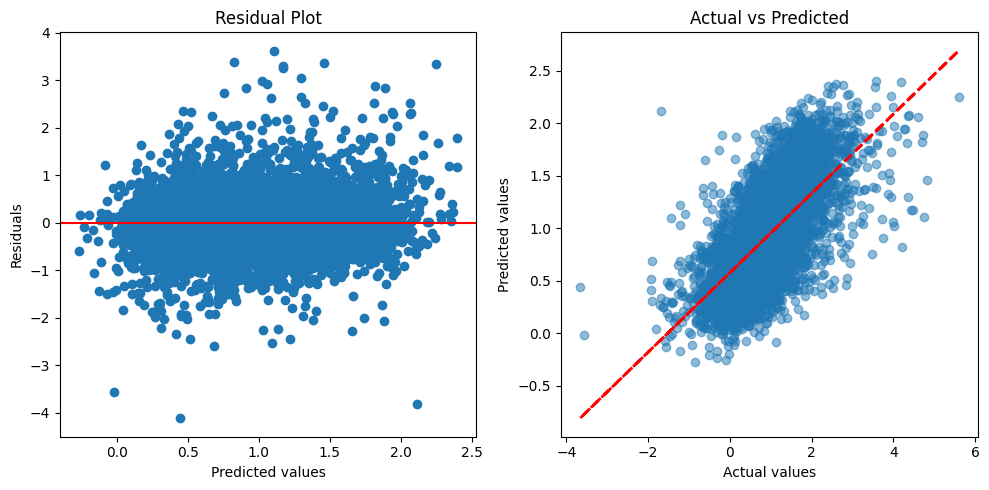

                                     Value
Mean Absolute Error (MAE)           0.4616
Mean Squared Error (MSE)            0.3932
Root Mean Squared Error (RMSE)      0.6270
R-squared                           0.4427
Adjusted R-squared                  0.4232
Durbin-Watson                       2.0059
Shapiro-Wilk Statistic              0.9681
Shapiro-Wilk p-value                0.0000
AIC                             10718.6359
BIC                             11933.1829
KNeighborsRegressor
y_test_df.shape:(5436, 1)
y_hat_df.shape:(5436, 1)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


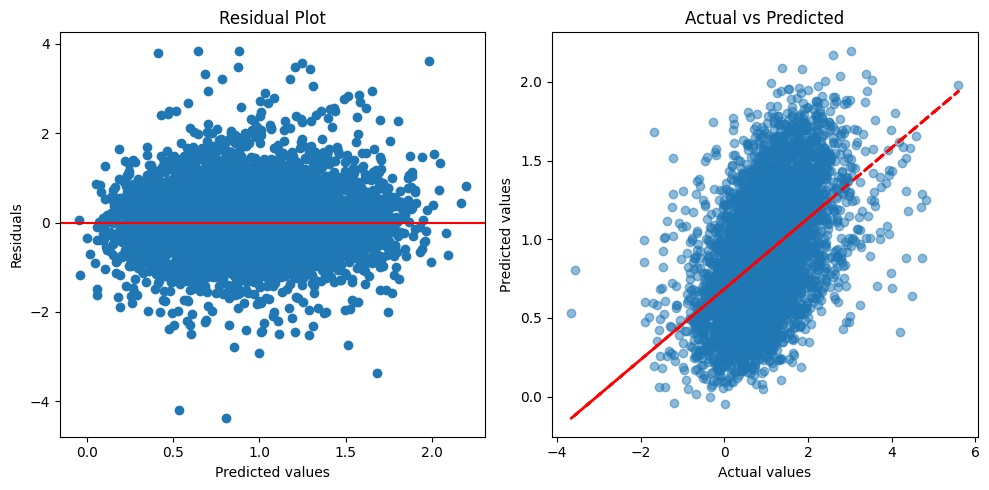

                                     Value
Mean Absolute Error (MAE)           0.5468
Mean Squared Error (MSE)            0.5306
Root Mean Squared Error (RMSE)      0.7285
R-squared                           0.2478
Adjusted R-squared                  0.2215
Durbin-Watson                       2.0146
Shapiro-Wilk Statistic              0.9778
Shapiro-Wilk p-value                0.0000
AIC                             12328.1939
BIC                             13542.7408
Iteration 1, loss = 0.22368859
Validation score: 0.240396
Iteration 2, loss = 0.12678081
Validation score: 0.316158
Iteration 3, loss = 0.11552255
Validation score: 0.338430
Iteration 4, loss = 0.10935553
Validation score: 0.346709
Iteration 5, loss = 0.10489462
Validation score: 0.353345
Iteration 6, loss = 0.10189081
Validation score: 0.349896
Iteration 7, loss = 0.09862744
Validation score: 0.351943
Iteration 8, loss = 0.09612262
Validation score: 0.355159
Iteration 9, loss = 0.09423823
Validation score: 0.349355
Itera

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


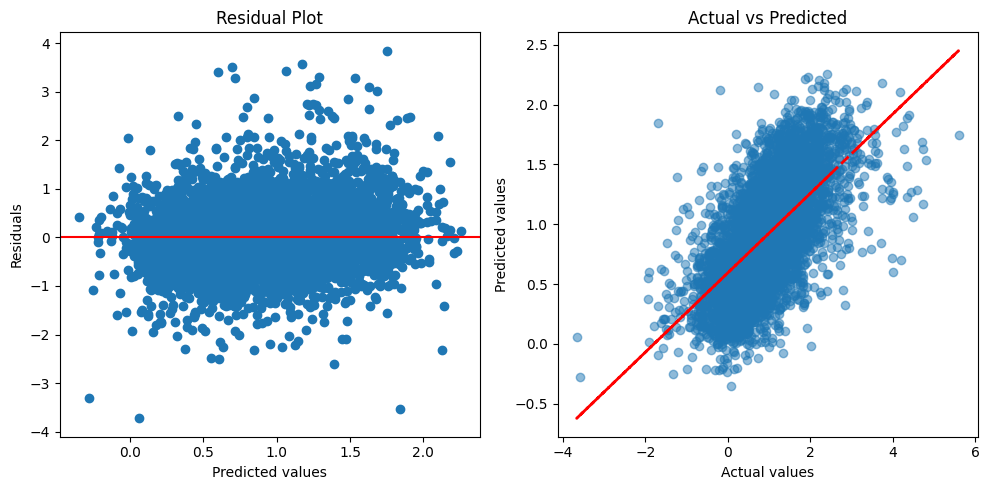

                                     Value
Mean Absolute Error (MAE)           0.4850
Mean Squared Error (MSE)            0.4310
Root Mean Squared Error (RMSE)      0.6565
R-squared                           0.3891
Adjusted R-squared                  0.3676
Durbin-Watson                       1.9959
Shapiro-Wilk Statistic              0.9708
Shapiro-Wilk p-value                0.0000
AIC                             11203.7604
BIC                             12418.3074
Iteration 1, loss = 0.59690021
Validation score: -1.146058
Iteration 2, loss = 0.28415463
Validation score: -0.296084
Iteration 3, loss = 0.17560615
Validation score: 0.043763
Iteration 4, loss = 0.14000437
Validation score: 0.143483
Iteration 5, loss = 0.12935535
Validation score: 0.182914
Iteration 6, loss = 0.12404344
Validation score: 0.207886
Iteration 7, loss = 0.12034671
Validation score: 0.217055
Iteration 8, loss = 0.11738617
Validation score: 0.238540
Iteration 9, loss = 0.11512541
Validation score: 0.249743
Ite

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


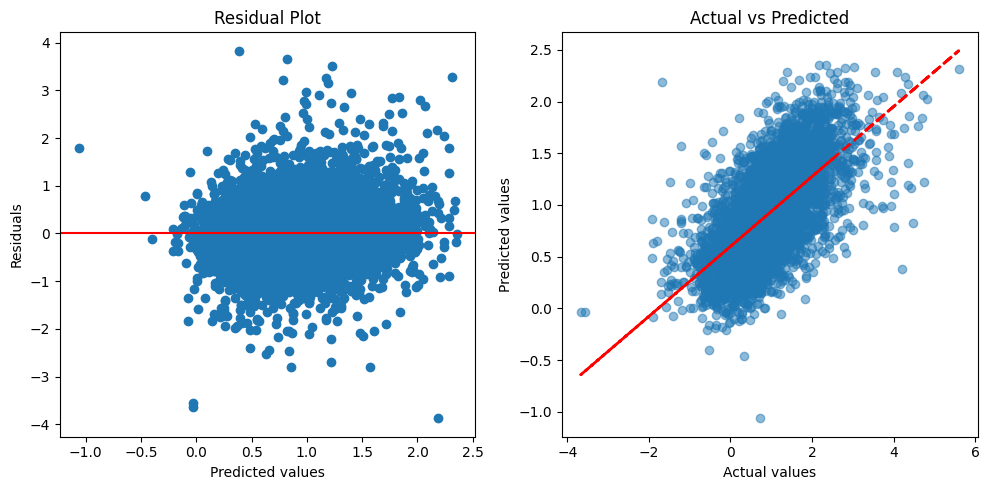

                                     Value
Mean Absolute Error (MAE)           0.4801
Mean Squared Error (MSE)            0.4219
Root Mean Squared Error (RMSE)      0.6496
R-squared                           0.4019
Adjusted R-squared                  0.3809
Durbin-Watson                       2.0141
Shapiro-Wilk Statistic              0.9704
Shapiro-Wilk p-value                0.0000
AIC                             11096.5679
BIC                             12311.1148


In [ ]:
#=================================================================
# TEST DIFFERENT MODELS (ON THE DATA SET WITH NO FPG) USING A REGRESSION APPROACH
#=================================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import math
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm

# Load data
directory = 'THE_FINAL_MASTER_DATASET(-16,-XHOMA,-33.3,-60%_0,-FPI,-FPG)4.csv'
df = pd.read_csv(directory, low_memory=False)

# Drop row 21396
#df.drop(21396, inplace=True)  # This drops the row by its index
#df.drop(18506, inplace=True)
#df.drop(22597, inplace=True)
#df.drop( 26446, inplace=True)

# Set 'seqn' as the index
df.set_index('seqn', inplace=True)

# Convert object columns to numeric categories
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.factorize(df[col])[0]

# Split data
y = df['homa-ir']
X = df.drop(columns=['homa-ir'])

test_type = 3
X_train, y_train, X_test, y_test = preprocess(X, y)

models = ["stepwise_regression", "RandomForestRegressor", "XGBRegressor", "KNeighborsRegressor", "MLPRegressor", "MLPRegressor_simple"]
#models = ["stepwise_regression"]

for mod in models:
  if mod == "stepwise_regression":
    mod, selected_col_nos = stepwise_regression(X_train, y_train, X_test, y_test, 10)
    y_hat = predict_with_selected_model(X_test[:, selected_col_nos], mod)
  elif mod == 'RandomForestRegressor':
    # Train Random Forest Regressor
    regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    regressor.fit(X_train, y_train)
    y_hat = regressor.predict(X_test)
  elif mod == "XGBRegressor":
    xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    xgb_regressor.fit(X_train, y_train)
    y_hat = xgb_regressor.predict(X_test)
  elif mod == "KNeighborsRegressor":
    # Step 1: Scaling the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)  # If you have a test set and you want to scale it

    # Step 2: Applying KNN regression
    k = 5  # You can choose any value for k, but 5 is a common starting point
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    knn_regressor.fit(X_train_scaled, y_train)

    # Predicting on the training set (or on a test set if you have one)
    y_hat = knn_regressor.predict(X_test_scaled)

  elif mod == "MLPRegressor":
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)


    # Initializing the MLP regressor
    mlp_regressor = MLPRegressor(hidden_layer_sizes=(50, 30),  # 2 hidden layers: 50 neurons in the first layer, 30 in the second
                                activation='tanh',           # Activation function
                                solver='adam',               # Optimization algorithm
                                max_iter=1000,               # Maximum iterations (epochs)
                                early_stopping=True,         # Stop training when validation score is not improving
                                validation_fraction=0.1,     # 10% of training data will be used as validation
                                verbose=True)                # Print progress

    # Fit the regressor
    mlp_regressor.fit(X_train_scaled, y_train)

    # Predicting on the training set
    y_hat = mlp_regressor.predict(X_test_scaled)
  elif mod == "MLPRegressor_simple":
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)


    # Initializing the MLP regressor
    mlp_regressor = MLPRegressor(hidden_layer_sizes=(10),  # 2 hidden layers: 50 neurons in the first layer, 30 in the second
                                activation='tanh',           # Activation function
                                solver='adam',               # Optimization algorithm
                                max_iter=1000,               # Maximum iterations (epochs)
                                early_stopping=True,         # Stop training when validation score is not improving
                                validation_fraction=0.1,     # 10% of training data will be used as validation
                                verbose=True)                # Print progress

    # Fit the regressor
    mlp_regressor.fit(X_train_scaled, y_train)

    # Predicting on the training set
    y_hat = mlp_regressor.predict(X_test_scaled)
  else:
    raise ("MOD TYPE NOT FOUND")
  n_features = X_train.shape[1]

  print(mod)
  y_test_df = pd.DataFrame(y_test, columns=["y_test"])
  y_hat_df = pd.DataFrame(y_hat, columns=["y_hat"])

  print("y_test_df.shape:" + str(y_test_df.shape))
  print("y_hat_df.shape:" + str(y_hat_df.shape))

  summary = model_evaluation(y_test_df, y_hat_df, n_features)
  print(summary)

Regression With log(HOMA-IR)

TEST R2: 0.2631; Feature: [63]
TEST R2: 0.2996; Feature: [63, 120]
TEST R2: 0.3481; Feature: [63, 120, 34]
TEST R2: 0.3626; Feature: [63, 120, 34, 43]
TEST R2: 0.3770; Feature: [63, 120, 34, 43, 104]
TEST R2: 0.3876; Feature: [63, 120, 34, 43, 104, 58]
TEST R2: 0.3980; Feature: [63, 120, 34, 43, 104, 58, 30]
TEST R2: 0.4016; Feature: [63, 120, 34, 43, 104, 58, 30, 136]
TEST R2: 0.4065; Feature: [63, 120, 34, 43, 104, 58, 30, 136, 180]
TEST R2: 0.4087; Feature: [63, 120, 34, 43, 104, 58, 30, 136, 180, 66]
LinearRegression()
y_test_df.shape:(5436, 1)
y_hat_df.shape:(5436, 1)


p-value may not be accurate for N > 5000.


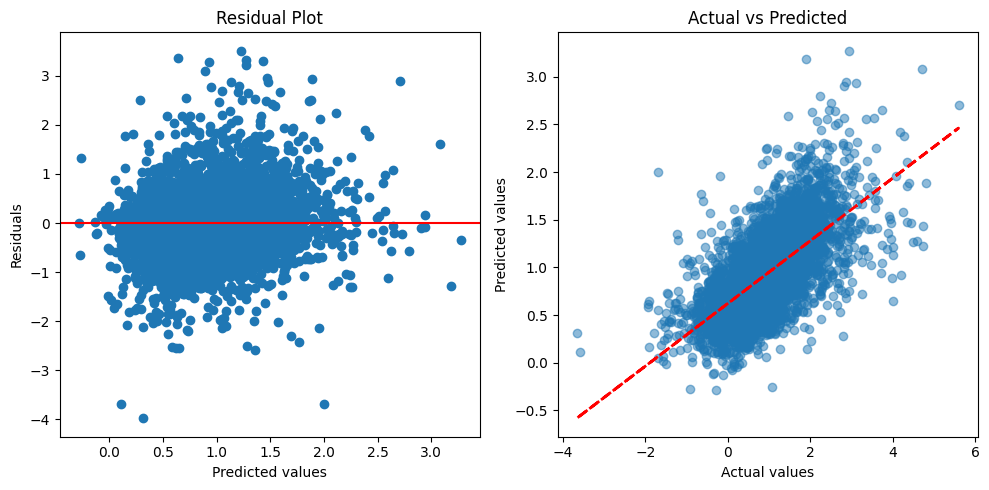

RandomForestRegressor
y_test_df.shape:(5436, 1)
y_hat_df.shape:(5436, 1)


p-value may not be accurate for N > 5000.


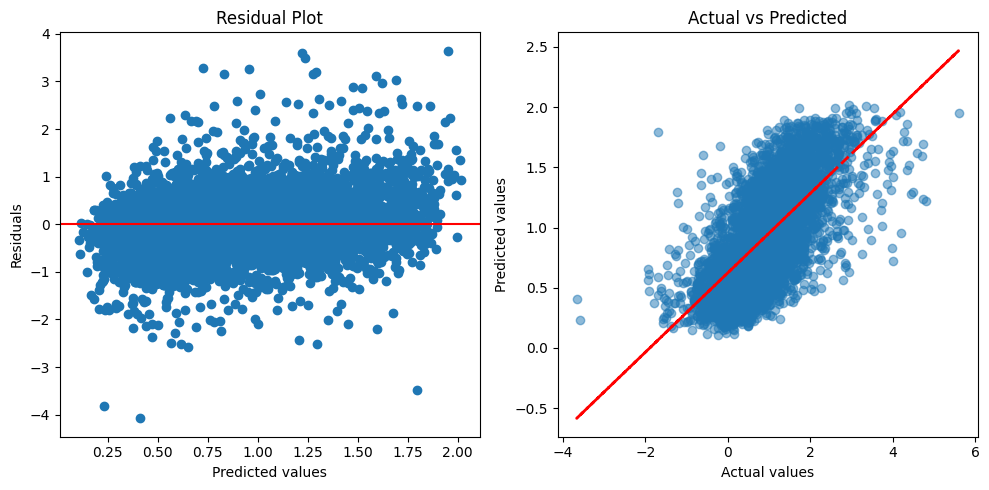

XGBRegressor
y_test_df.shape:(5436, 1)
y_hat_df.shape:(5436, 1)


p-value may not be accurate for N > 5000.


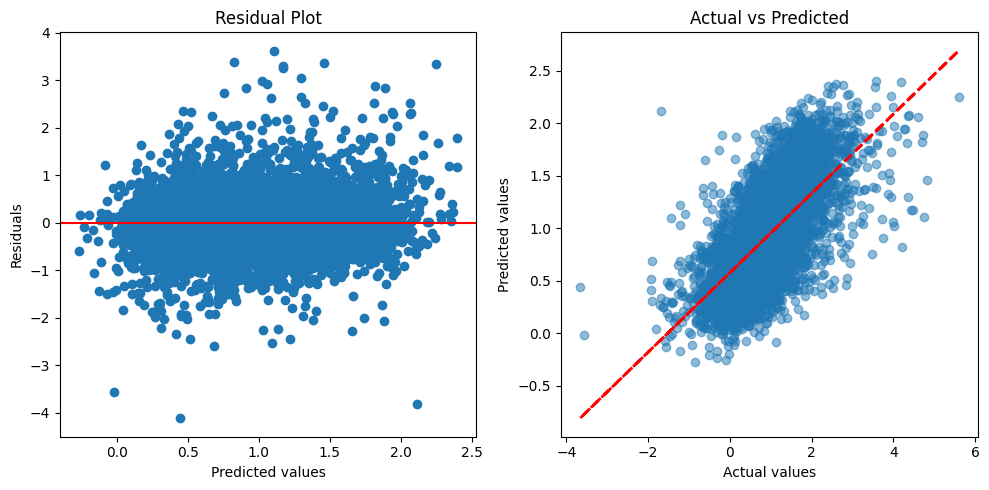

KNeighborsRegressor
y_test_df.shape:(5436, 1)
y_hat_df.shape:(5436, 1)


p-value may not be accurate for N > 5000.


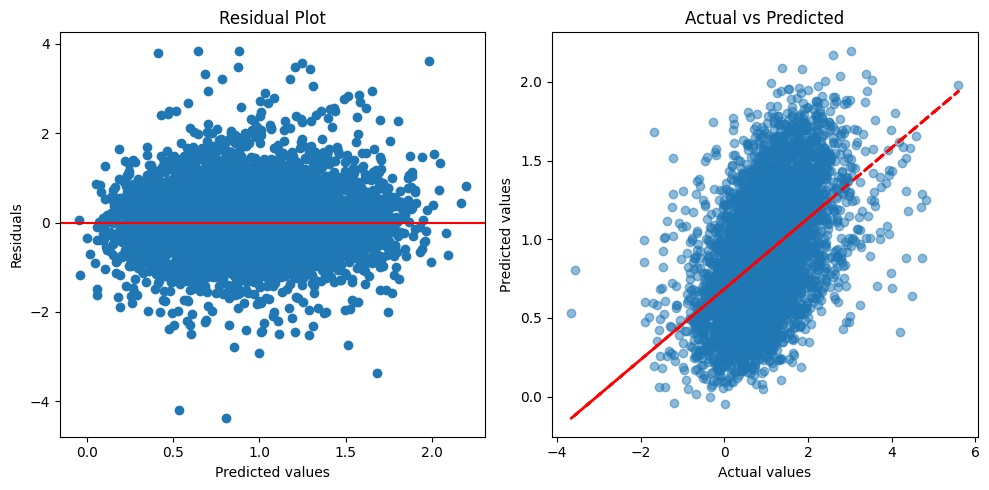

Iteration 1, loss = 0.37783137
Validation score: 0.179020
Iteration 2, loss = 0.13733606
Validation score: 0.290431
Iteration 3, loss = 0.12263173
Validation score: 0.317519
Iteration 4, loss = 0.11459801
Validation score: 0.342134
Iteration 5, loss = 0.10861956
Validation score: 0.353860
Iteration 6, loss = 0.10442576
Validation score: 0.361185
Iteration 7, loss = 0.10173171
Validation score: 0.365102
Iteration 8, loss = 0.09919838
Validation score: 0.368228
Iteration 9, loss = 0.09680925
Validation score: 0.362694
Iteration 10, loss = 0.09481988
Validation score: 0.369272
Iteration 11, loss = 0.09272929
Validation score: 0.358627
Iteration 12, loss = 0.09076199
Validation score: 0.363168
Iteration 13, loss = 0.08920523
Validation score: 0.357736
Iteration 14, loss = 0.08711176
Validation score: 0.348824
Iteration 15, loss = 0.08565153
Validation score: 0.349915
Iteration 16, loss = 0.08395787
Validation score: 0.345077
Iteration 17, loss = 0.08319815
Validation score: 0.343904
Iterat

p-value may not be accurate for N > 5000.


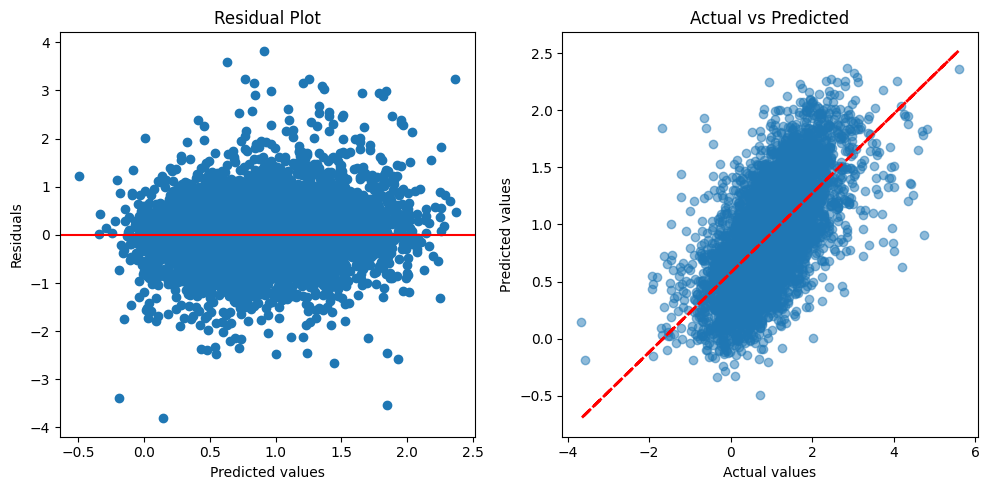

Iteration 1, loss = 0.59664123
Validation score: -0.868899
Iteration 2, loss = 0.25558160
Validation score: -0.092736
Iteration 3, loss = 0.17393884
Validation score: 0.119930
Iteration 4, loss = 0.14911012
Validation score: 0.213043
Iteration 5, loss = 0.13821613
Validation score: 0.247388
Iteration 6, loss = 0.13173583
Validation score: 0.270613
Iteration 7, loss = 0.12697043
Validation score: 0.292698
Iteration 8, loss = 0.12219353
Validation score: 0.309456
Iteration 9, loss = 0.11916796
Validation score: 0.325104
Iteration 10, loss = 0.11650521
Validation score: 0.334138
Iteration 11, loss = 0.11474856
Validation score: 0.335321
Iteration 12, loss = 0.11265834
Validation score: 0.349887
Iteration 13, loss = 0.11146450
Validation score: 0.357161
Iteration 14, loss = 0.11014481
Validation score: 0.357549
Iteration 15, loss = 0.10905491
Validation score: 0.367992
Iteration 16, loss = 0.10785979
Validation score: 0.358659
Iteration 17, loss = 0.10732700
Validation score: 0.362545
Iter

p-value may not be accurate for N > 5000.


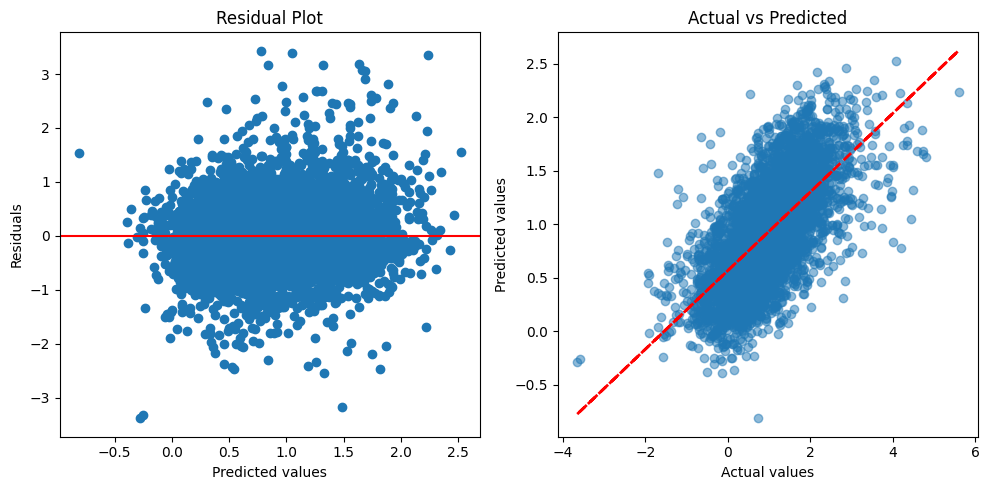

In [ ]:
#REGRESSION APPROACH WITH LOG(HOMA-IR)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import math
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm

# Load data
directory = 'THE_FINAL_MASTER_DATASET(-16,-XHOMA,-33.3,-60%_0,-FPI,-FPG)4.csv'
df = pd.read_csv(directory, low_memory=False)

# Drop row 21396
#df.drop(21396, inplace=True)  # This drops the row by its index
#df.drop(18506, inplace=True)
#df.drop(22597, inplace=True)
#df.drop( 26446, inplace=True)

# Set 'seqn' as the index
df.set_index('seqn', inplace=True)

# Convert object columns to numeric categories
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.factorize(df[col])[0]

  # Log-transforming the HOMA-IR values
y = np.log(df['homa-ir'] + 1)  # we add 1 to ensure the log is defined for values that are 0

# Split data
y = df['homa-ir']
X = df.drop(columns=['homa-ir'])

test_type = 3
X_train, y_train, X_test, y_test = preprocess(X, y)

models = ["stepwise_regression", "RandomForestRegressor", "XGBRegressor", "KNeighborsRegressor", "MLPRegressor", "MLPRegressor_simple"]
#models = ["stepwise_regression"]

for mod in models:
  if mod == "stepwise_regression":
    mod, selected_col_nos = stepwise_regression(X_train, y_train, X_test, y_test, 10)
    y_hat = predict_with_selected_model(X_test[:, selected_col_nos], mod)
  elif mod == 'RandomForestRegressor':
    # Train Random Forest Regressor
    regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    regressor.fit(X_train, y_train)
    y_hat = regressor.predict(X_test)
  elif mod == "XGBRegressor":
    xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    xgb_regressor.fit(X_train, y_train)
    y_hat = xgb_regressor.predict(X_test)
  elif mod == "KNeighborsRegressor":
    # Step 1: Scaling the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)  # If you have a test set and you want to scale it

    # Step 2: Applying KNN regression
    k = 5  # You can choose any value for k, but 5 is a common starting point
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    knn_regressor.fit(X_train_scaled, y_train)

    # Predicting on the training set (or on a test set if you have one)
    y_hat = knn_regressor.predict(X_test_scaled)

  elif mod == "MLPRegressor":
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)


    # Initializing the MLP regressor
    mlp_regressor = MLPRegressor(hidden_layer_sizes=(50, 30),  # 2 hidden layers: 50 neurons in the first layer, 30 in the second
                                activation='tanh',           # Activation function
                                solver='adam',               # Optimization algorithm
                                max_iter=1000,               # Maximum iterations (epochs)
                                early_stopping=True,         # Stop training when validation score is not improving
                                validation_fraction=0.1,     # 10% of training data will be used as validation
                                verbose=True)                # Print progress

    # Fit the regressor
    mlp_regressor.fit(X_train_scaled, y_train)

    # Predicting on the training set
    y_hat = mlp_regressor.predict(X_test_scaled)
  elif mod == "MLPRegressor_simple":
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)


    # Initializing the MLP regressor
    mlp_regressor = MLPRegressor(hidden_layer_sizes=(10),  # 2 hidden layers: 50 neurons in the first layer, 30 in the second
                                activation='tanh',           # Activation function
                                solver='adam',               # Optimization algorithm
                                max_iter=1000,               # Maximum iterations (epochs)
                                early_stopping=True,         # Stop training when validation score is not improving
                                validation_fraction=0.1,     # 10% of training data will be used as validation
                                verbose=True)                # Print progress

    # Fit the regressor
    mlp_regressor.fit(X_train_scaled, y_train)

    # Predicting on the training set
    y_hat = mlp_regressor.predict(X_test_scaled)
  else:
    raise ("MOD TYPE NOT FOUND")
  n_features = X_train.shape[1]

  print(mod)
  y_test_df = pd.DataFrame(y_test, columns=["y_test"])
  y_hat_df = pd.DataFrame(y_hat, columns=["y_hat"])

  print("y_test_df.shape:" + str(y_test_df.shape))
  print("y_hat_df.shape:" + str(y_hat_df.shape))

  summary = model_evaluation(y_test_df, y_hat_df, n_features)

Classifictaion Aproach

In [ ]:
#=================================================================
# TEST DIFFERENT MODELS (ON THE DATASET WITH NO FPG) USING A CLASSIFICATION APPROACH
#=================================================================
#RUN FIRST
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Load data
directory = 'THE_FINAL_MASTER_DATASET(-16,-XHOMA,-33.3,-60%_0,-FPI,-FPG)4.csv'
df = pd.read_csv(directory, low_memory=False)


# Drop the specified columns from the actual dataset
df = df.drop(columns=['wtsaf2yr', 'wtsaf2yr_x', 'sdmvstra', 'sddsrvyr', 'wtmec2yr', 'slq030', 'wtint2yr', 'wtsog2yr', 'peasctm1', 'bmxht', 'bmxleg'])


# Set 'seqn' as the index
df.set_index('seqn', inplace=True)

# Convert object columns to numeric categories
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.factorize(df[col])[0]

# Convert "homa-ir" to binary values for classification
df['homa-ir'] = (df['homa-ir'] > 2.5).astype(int)

# Split data
y = df['homa-ir']
X = df.drop(columns=['homa-ir'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = ["LogisticRegression", "RandomForestClassifier", "XGBClassifier", "KNeighborsClassifier", "MLPClassifier"]


# Impute missing values
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

for mod in models:
    if mod == "LogisticRegression":
        classifier = LogisticRegression(max_iter=10000, random_state=42)
        classifier.fit(X_train_scaled, y_train)
        y_pred = classifier.predict(X_test_scaled)
    elif mod == 'RandomForestClassifier':
        classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        classifier.fit(X_train_imputed, y_train)  # Use imputed data
        y_pred = classifier.predict(X_test_imputed)  # Use imputed data
    elif mod == "XGBClassifier":
        classifier = xgb.XGBClassifier(n_estimators=100)
        classifier.fit(X_train_imputed, y_train)  # Use imputed data
        y_pred = classifier.predict(X_test_imputed)  # Use imputed data
    elif mod == "KNeighborsClassifier":
        classifier = KNeighborsClassifier(n_neighbors=5)
        classifier.fit(X_train_scaled, y_train)
        y_pred = classifier.predict(X_test_scaled)
    elif mod == "MLPClassifier":
        classifier = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42)
        classifier.fit(X_train_scaled, y_train)
        y_pred = classifier.predict(X_test_scaled)
    else:
        raise ValueError("MODEL TYPE NOT FOUND")

    print(mod)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("-" * 50)

LogisticRegression
Accuracy: 0.7583
F1-Score: 0.7443
Confusion Matrix:
[[2210  571]
 [ 743 1912]]
--------------------------------------------------
RandomForestClassifier
Accuracy: 0.7666
F1-Score: 0.7546
Confusion Matrix:
[[2216  565]
 [ 704 1951]]
--------------------------------------------------
XGBClassifier
Accuracy: 0.7586
F1-Score: 0.7484
Confusion Matrix:
[[2173  608]
 [ 704 1951]]
--------------------------------------------------
KNeighborsClassifier
Accuracy: 0.6696
F1-Score: 0.6369
Confusion Matrix:
[[2065  716]
 [1080 1575]]
--------------------------------------------------
MLPClassifier
Accuracy: 0.6943
F1-Score: 0.6827
Confusion Matrix:
[[1986  795]
 [ 867 1788]]
--------------------------------------------------


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.6 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



----------------------------------------
LogisticRegression
Accuracy: 0.7772
F1 Score: 0.7641
Confusion Matrix:
[[2264  517]
 [ 694 1961]]


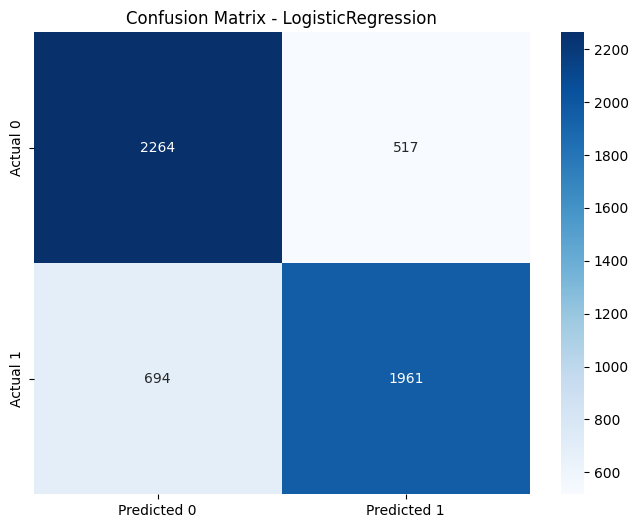

ROC AUC: 0.8599


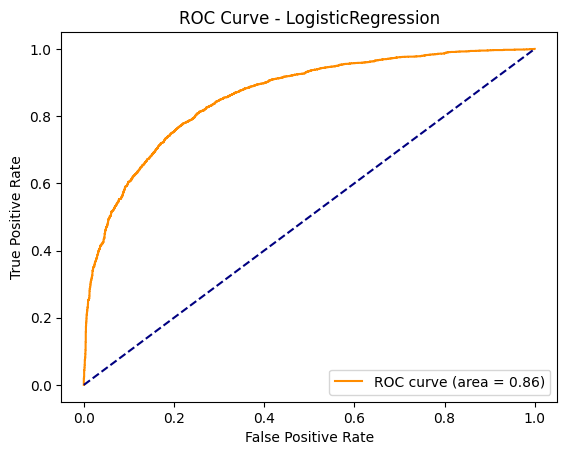


----------------------------------------
RandomForestClassifier
Accuracy: 0.7829
F1 Score: 0.7714
Confusion Matrix:
[[2265  516]
 [ 664 1991]]


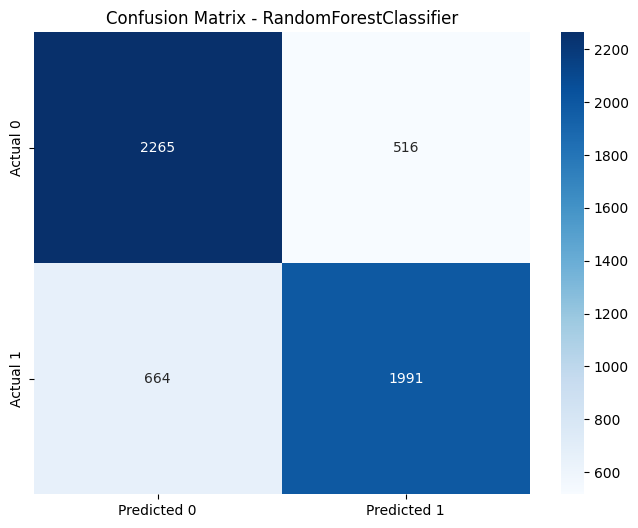

ROC AUC: 0.8640


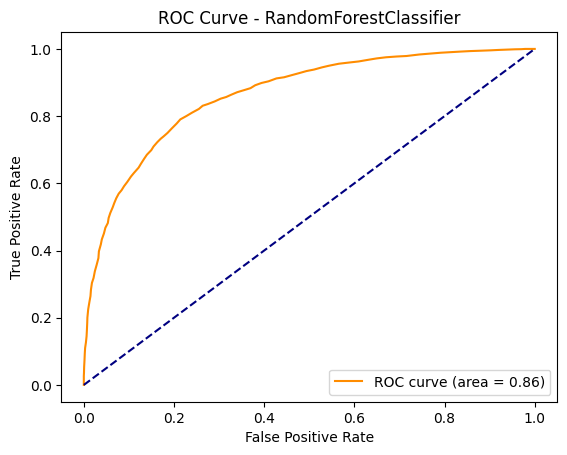


----------------------------------------
XGBClassifier
Accuracy: 0.7850
F1 Score: 0.7777
Confusion Matrix:
[[2222  559]
 [ 610 2045]]


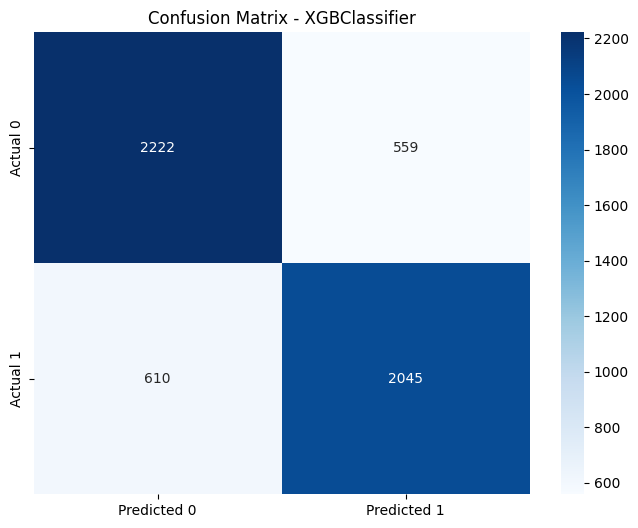

ROC AUC: 0.8699


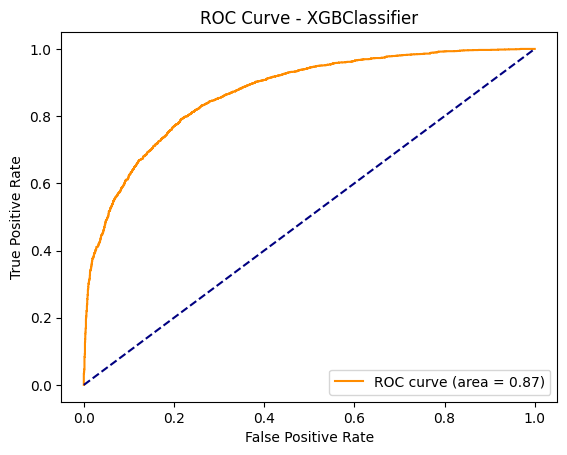


----------------------------------------
KNeighborsClassifier
Accuracy: 0.6762
F1 Score: 0.6424
Confusion Matrix:
[[2095  686]
 [1074 1581]]


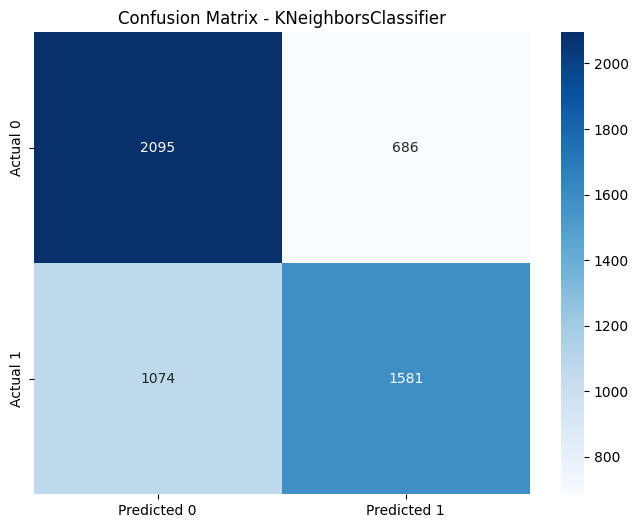

ROC AUC: 0.7334


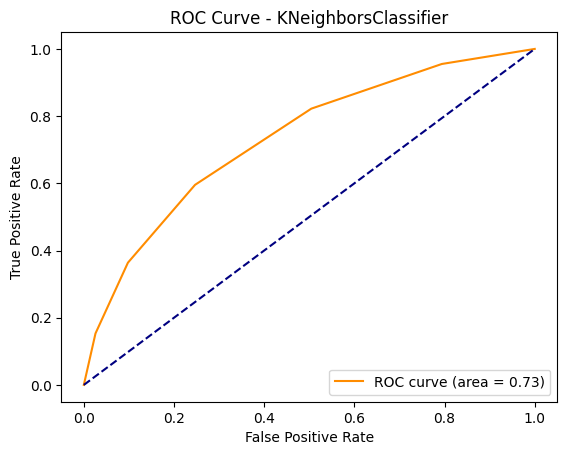


----------------------------------------
MLPClassifier
Accuracy: 0.7114
F1 Score: 0.7037
Confusion Matrix:
[[2004  777]
 [ 792 1863]]


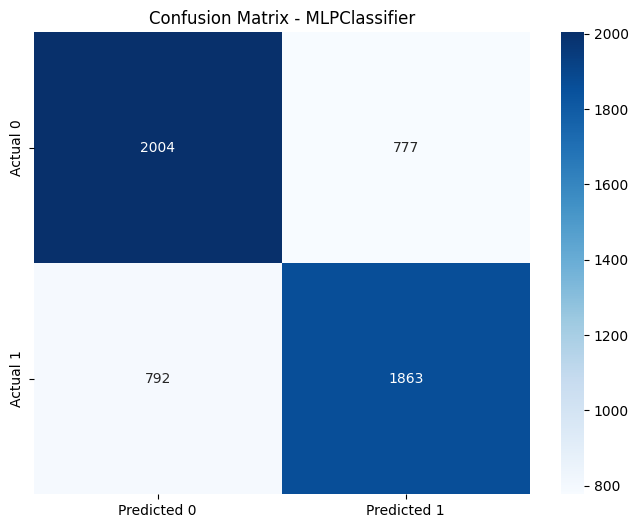

ROC AUC: 0.7823


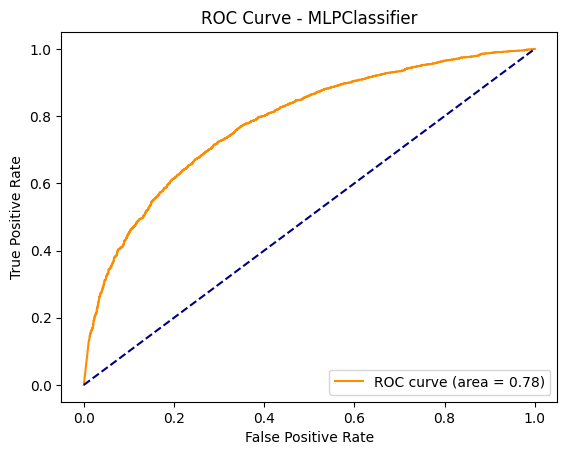

In [ ]:
#AUC ROC and CONFUSION MATRIX (on the dataset without FPG)-Classification Approach
!pip install shap

import pandas as pd
import shap
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns

# Load data
directory = 'THE_FINAL_MASTER_DATASET(-16,-XHOMA,-33.3,-60%_0,-FPI)2.csv'
df = pd.read_csv(directory, low_memory=False)
df.set_index('seqn', inplace=True)

# Drop the specified columns from the actual dataset
df = df.drop(columns=['wtsaf2yr', 'wtsaf2yr_x', 'sdmvstra', 'sddsrvyr', 'wtmec2yr', 'slq030', 'wtint2yr', 'wtsog2yr', 'peasctm1', 'bmxht'])


# Convert object columns to numeric categories
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.factorize(df[col])[0]

# Convert "homa-ir" to binary values for classification
df['homa-ir'] = (df['homa-ir'] > 2.5).astype(int)

# Split data
y = df['homa-ir']
X = df.drop(columns=['homa-ir'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

model_dict = {
    "LogisticRegression": (LogisticRegression(max_iter=10000, random_state=42), True),
    "RandomForestClassifier": (RandomForestClassifier(n_estimators=100, random_state=42), False),
    "XGBClassifier": (XGBClassifier(n_estimators=100), False),
    "KNeighborsClassifier": (KNeighborsClassifier(n_neighbors=5), True),
    "MLPClassifier": (MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42), True)
}

for mod, (classifier, uses_scaled_data) in model_dict.items():
    if uses_scaled_data:
        classifier.fit(X_train_scaled, y_train)
        y_pred = classifier.predict(X_test_scaled)
        y_pred_prob = classifier.predict_proba(X_test_scaled)[:, 1]
    else:
        classifier.fit(X_train_imputed, y_train)
        y_pred = classifier.predict(X_test_imputed)
        y_pred_prob = classifier.predict_proba(X_test_imputed)[:, 1]

    print("\n" + "-"*40)
    print(mod)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")



 # Confusion Matrix Heatmap Visualization
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix - {mod}')
    plt.show()



    # Compute and plot ROC curve within the for loop
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    print(f"ROC AUC: {roc_auc:.4f}")

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {mod}')
    plt.legend(loc="lower right")
    plt.show()


LogisticRegression
Accuracy: 0.7583
F1-Score: 0.7443
Confusion Matrix:
[[2210  571]
 [ 743 1912]]
--------------------------------------------------


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


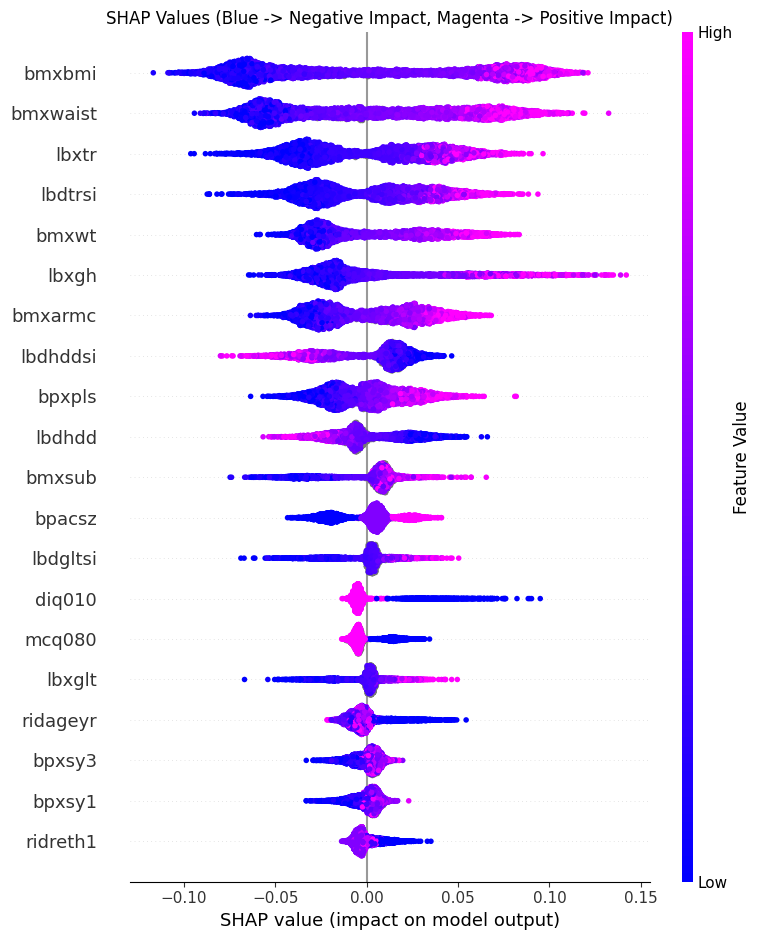

RandomForestClassifier
Accuracy: 0.7666
F1-Score: 0.7546
Confusion Matrix:
[[2216  565]
 [ 704 1951]]
--------------------------------------------------
XGBClassifier
Accuracy: 0.7586
F1-Score: 0.7484
Confusion Matrix:
[[2173  608]
 [ 704 1951]]
--------------------------------------------------
KNeighborsClassifier
Accuracy: 0.6696
F1-Score: 0.6369
Confusion Matrix:
[[2065  716]
 [1080 1575]]
--------------------------------------------------
MLPClassifier
Accuracy: 0.6943
F1-Score: 0.6827
Confusion Matrix:
[[1986  795]
 [ 867 1788]]
--------------------------------------------------


In [ ]:
#Shap values for RandomForest (on dataset without FPG) - Classification Approach
# Import necessary libraries
!pip install shap

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import shap  # <-- ADD THIS
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier


# Load data
directory = 'THE_FINAL_MASTER_DATASET(-16,-XHOMA,-33.3,-60%_0,-FPI,-FPG)4.csv'
df = pd.read_csv(directory, low_memory=False)


# Drop the specified columns from the actual dataset
df = df.drop(columns=['wtsaf2yr', 'wtsaf2yr_x', 'sdmvstra', 'sddsrvyr', 'wtmec2yr', 'slq030', 'wtint2yr', 'wtsog2yr', 'peasctm1', 'bmxht', 'bmxleg'])


# Set 'seqn' as the index
df.set_index('seqn', inplace=True)

# Convert object columns to numeric categories
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.factorize(df[col])[0]

# Convert "homa-ir" to binary values for classification
df['homa-ir'] = (df['homa-ir'] > 2.5).astype(int)

# Split data
y = df['homa-ir']
X = df.drop(columns=['homa-ir'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = ["LogisticRegression", "RandomForestClassifier", "XGBClassifier", "KNeighborsClassifier", "MLPClassifier"]


# Impute missing values
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

for mod in models:
    if mod == "LogisticRegression":
        classifier = LogisticRegression(max_iter=10000, random_state=42)
        classifier.fit(X_train_scaled, y_train)
        y_pred = classifier.predict(X_test_scaled)
    #elif mod == 'RandomForestClassifier':
        #classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        #classifier.fit(X_train_imputed, y_train)  # Use imputed data
        #y_pred = classifier.predict(X_test_imputed)  # Use imputed data

        # --- SHAP Plot for Random Forest ---
        #explainer = shap.Explainer(classifier)
        #shap_values = explainer.shap_values(X_test_imputed)
        #shap.summary_plot(shap_values[1], X_test, color_bar_label="Feature Value", cmap="bwr", show=False)  # 'bwr' is a blue-white-red colormap

        #plt.title("SHAP Values (Blue -> Negative Impact, Pink -> Positive Impact)")
        #plt.tight_layout()
        #plt.show()

    elif mod == 'RandomForestClassifier':
      classifier = RandomForestClassifier(n_estimators=100, random_state=42)
      classifier.fit(X_train_imputed, y_train)  # Use imputed data
      y_pred = classifier.predict(X_test_imputed)  # Use imputed data

      # --- SHAP Plot for Random Forest ---
      explainer = shap.Explainer(classifier)
      shap_values = explainer.shap_values(X_test_imputed)

      # Define a custom blue-magenta colormap
      colors = [(0, 0, 1), (1, 0, 1)]  # Blue -> Magenta
      n_bins = [3, 10, 100, 1000]  # Discretizes the interpolation into bins
      cmap_name = 'blue_magenta'
      cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

      shap.summary_plot(shap_values[1], X_test, color_bar_label="Feature Value", cmap=cm, show=False)

      plt.title("SHAP Values (Blue -> Negative Impact, Magenta -> Positive Impact)")
      plt.tight_layout()
      plt.show()

    elif mod == "XGBClassifier":
        classifier = xgb.XGBClassifier(n_estimators=100)
        classifier.fit(X_train_imputed, y_train)  # Use imputed data
        y_pred = classifier.predict(X_test_imputed)  # Use imputed data
    elif mod == "KNeighborsClassifier":
        classifier = KNeighborsClassifier(n_neighbors=5)
        classifier.fit(X_train_scaled, y_train)
        y_pred = classifier.predict(X_test_scaled)
    elif mod == "MLPClassifier":
        classifier = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42)
        classifier.fit(X_train_scaled, y_train)
        y_pred = classifier.predict(X_test_scaled)
    else:
        raise ValueError("MODEL TYPE NOT FOUND")

    print(mod)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("-" * 50)

Classifiction on Dataset wiith log(HOMA-IR)

In [ ]:
#CLASSIFICATIONON DATASET WITH LOG(HOMA-IR)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Load data
directory = 'THE_FINAL_MASTER_DATASET(-16,-XHOMA,-33.3,-60%_0,-FPI,-FPG)4.csv'
df = pd.read_csv(directory, low_memory=False)


# Drop the specified columns from the actual dataset
df = df.drop(columns=['wtsaf2yr', 'wtsaf2yr_x', 'sdmvstra', 'sddsrvyr', 'wtmec2yr', 'slq030', 'wtint2yr', 'wtsog2yr', 'peasctm1', 'bmxht', 'bmxleg'])

# Log-transforming the HOMA-IR values
y = np.log(df['homa-ir'] + 1)  # we add 1 to ensure the log is defined for values that are 0

# Set 'seqn' as the index
df.set_index('seqn', inplace=True)

# Convert object columns to numeric categories
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.factorize(df[col])[0]

# Convert "homa-ir" to binary values for classification
df['homa-ir'] = (df['homa-ir'] > 0.39794).astype(int)

# Split data
y = df['homa-ir']
X = df.drop(columns=['homa-ir'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = ["LogisticRegression", "RandomForestClassifier", "XGBClassifier", "KNeighborsClassifier", "MLPClassifier"]


# Impute missing values
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

for mod in models:
    if mod == "LogisticRegression":
        classifier = LogisticRegression(max_iter=10000, random_state=42)
        classifier.fit(X_train_scaled, y_train)
        y_pred = classifier.predict(X_test_scaled)
    elif mod == 'RandomForestClassifier':
        classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        classifier.fit(X_train_imputed, y_train)  # Use imputed data
        y_pred = classifier.predict(X_test_imputed)  # Use imputed data
    elif mod == "XGBClassifier":
        classifier = xgb.XGBClassifier(n_estimators=100)
        classifier.fit(X_train_imputed, y_train)  # Use imputed data
        y_pred = classifier.predict(X_test_imputed)  # Use imputed data
    elif mod == "KNeighborsClassifier":
        classifier = KNeighborsClassifier(n_neighbors=5)
        classifier.fit(X_train_scaled, y_train)
        y_pred = classifier.predict(X_test_scaled)
    elif mod == "MLPClassifier":
        classifier = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42)
        classifier.fit(X_train_scaled, y_train)
        y_pred = classifier.predict(X_test_scaled)
    else:
        raise ValueError("MODEL TYPE NOT FOUND")

    print(mod)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("-" * 50)

LogisticRegression
Accuracy: 0.9893
F1-Score: 0.9946
Confusion Matrix:
[[   2   56]
 [   2 5376]]
--------------------------------------------------
RandomForestClassifier
Accuracy: 0.9893
F1-Score: 0.9946
Confusion Matrix:
[[   0   58]
 [   0 5378]]
--------------------------------------------------
XGBClassifier
Accuracy: 0.9891
F1-Score: 0.9945
Confusion Matrix:
[[   0   58]
 [   1 5377]]
--------------------------------------------------
KNeighborsClassifier
Accuracy: 0.9891
F1-Score: 0.9945
Confusion Matrix:
[[   0   58]
 [   1 5377]]
--------------------------------------------------
MLPClassifier
Accuracy: 0.9873
F1-Score: 0.9936
Confusion Matrix:
[[   2   56]
 [  13 5365]]
--------------------------------------------------



----------------------------------------
LogisticRegression
Accuracy: 0.9893
F1 Score: 0.9946
Confusion Matrix:
[[   5   53]
 [   5 5373]]


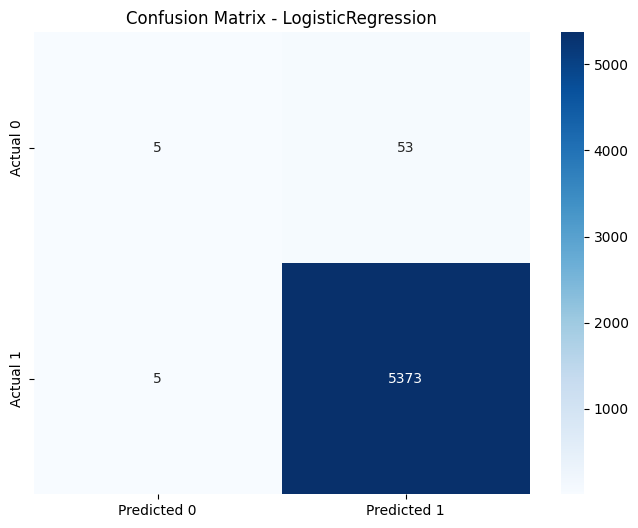

ROC AUC: 0.8809


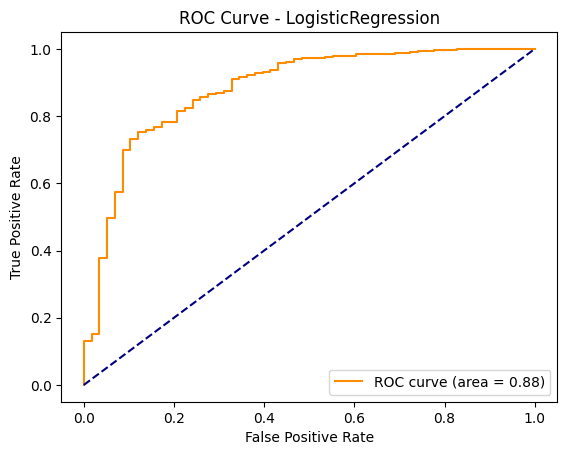


----------------------------------------
RandomForestClassifier
Accuracy: 0.9893
F1 Score: 0.9946
Confusion Matrix:
[[   0   58]
 [   0 5378]]


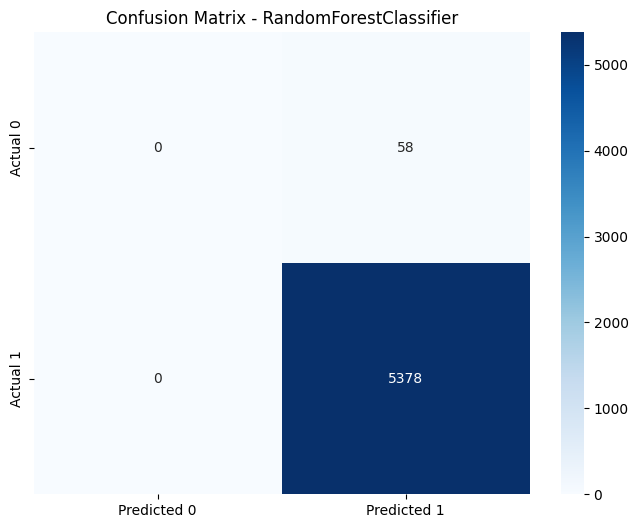

ROC AUC: 0.8728


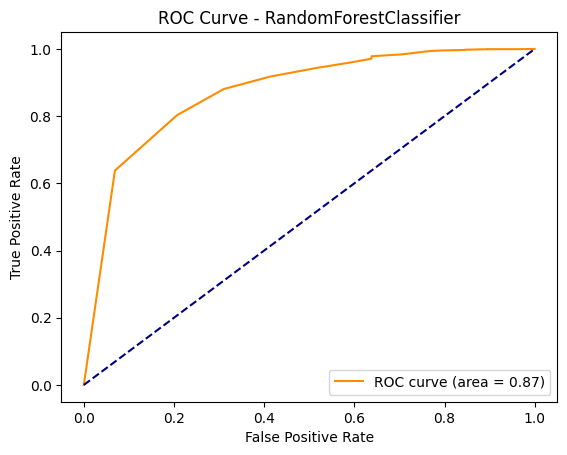


----------------------------------------
XGBClassifier
Accuracy: 0.9888
F1 Score: 0.9944
Confusion Matrix:
[[   1   57]
 [   4 5374]]


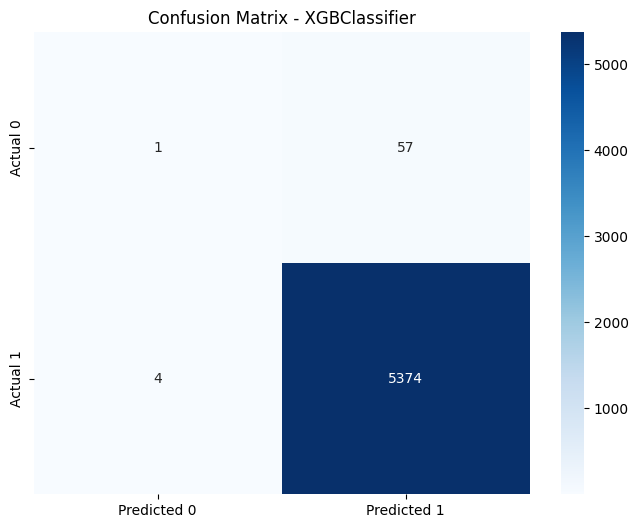

ROC AUC: 0.9215


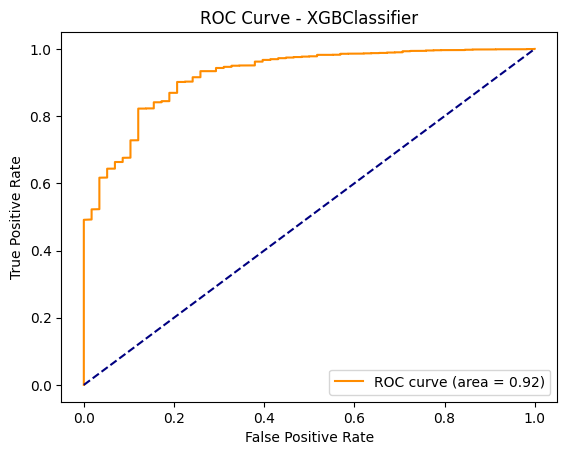


----------------------------------------
KNeighborsClassifier
Accuracy: 0.9891
F1 Score: 0.9945
Confusion Matrix:
[[   0   58]
 [   1 5377]]


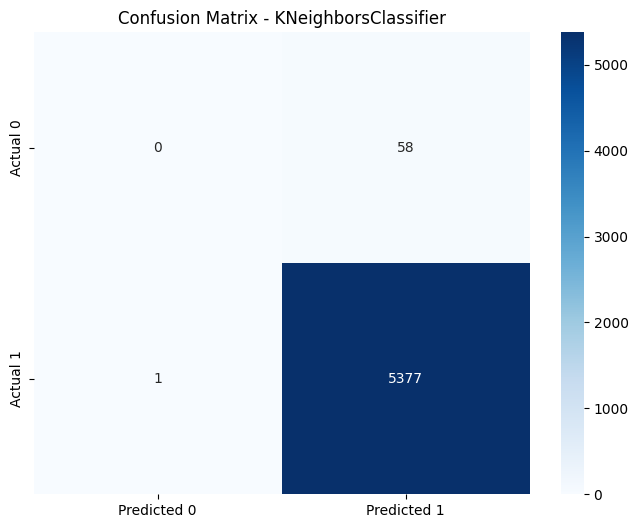

ROC AUC: 0.5728


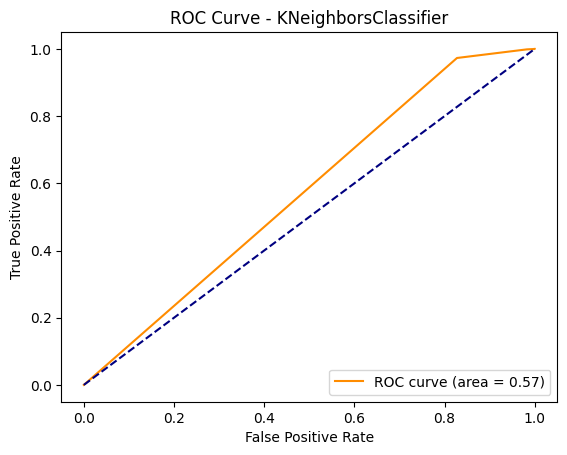


----------------------------------------
MLPClassifier
Accuracy: 0.9880
F1 Score: 0.9940
Confusion Matrix:
[[   4   54]
 [  11 5367]]


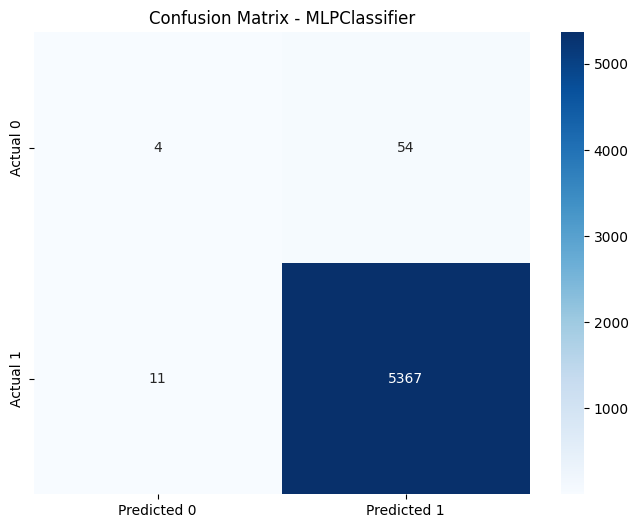

ROC AUC: 0.8347


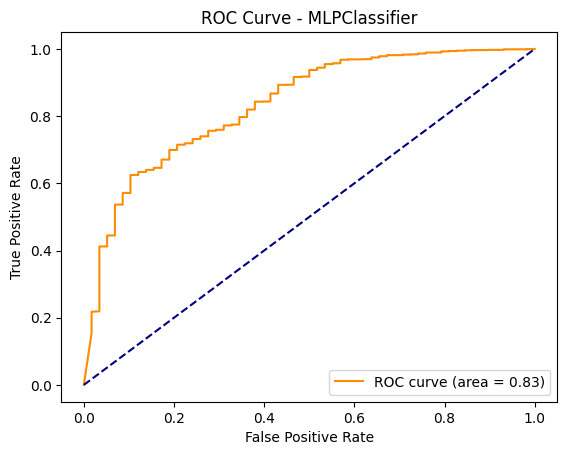

In [ ]:
#CLASSIFICATIONON DATASET WITH LOG(HOMA-IR)-- ROC AUC AND CONFUSION MATRIX
!pip install shap

import pandas as pd
import shap
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns

# Load data
directory = 'THE_FINAL_MASTER_DATASET(-16,-XHOMA,-33.3,-60%_0,-FPI)2.csv'
df = pd.read_csv(directory, low_memory=False)
df.set_index('seqn', inplace=True)

# Drop the specified columns from the actual dataset
df = df.drop(columns=['wtsaf2yr', 'wtsaf2yr_x', 'sdmvstra', 'sddsrvyr', 'wtmec2yr', 'slq030', 'wtint2yr', 'wtsog2yr', 'peasctm1', 'bmxht'])

# Log-transforming the HOMA-IR values
y = np.log(df['homa-ir'] + 1)  # we add 1 to ensure the log is defined for values that are 0

# Convert object columns to numeric categories
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.factorize(df[col])[0]

# Convert "homa-ir" to binary values for classification
df['homa-ir'] = (df['homa-ir'] > 0.39794).astype(int)

# Split data
y = df['homa-ir']
X = df.drop(columns=['homa-ir'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

model_dict = {
    "LogisticRegression": (LogisticRegression(max_iter=10000, random_state=42), True),
    "RandomForestClassifier": (RandomForestClassifier(n_estimators=100, random_state=42), False),
    "XGBClassifier": (XGBClassifier(n_estimators=100), False),
    "KNeighborsClassifier": (KNeighborsClassifier(n_neighbors=5), True),
    "MLPClassifier": (MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42), True)
}

for mod, (classifier, uses_scaled_data) in model_dict.items():
    if uses_scaled_data:
        classifier.fit(X_train_scaled, y_train)
        y_pred = classifier.predict(X_test_scaled)
        y_pred_prob = classifier.predict_proba(X_test_scaled)[:, 1]
    else:
        classifier.fit(X_train_imputed, y_train)
        y_pred = classifier.predict(X_test_imputed)
        y_pred_prob = classifier.predict_proba(X_test_imputed)[:, 1]

    print("\n" + "-"*40)
    print(mod)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")



 # Confusion Matrix Heatmap Visualization
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix - {mod}')
    plt.show()



    # Compute and plot ROC curve within the for loop
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    print(f"ROC AUC: {roc_auc:.4f}")

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {mod}')
    plt.legend(loc="lower right")
    plt.show()



In [ ]:
#Shap values for RandomForest (on dataset without FPG) - Classification Approach ON LOG(HOMA-IR)
# Import necessary libraries
!pip install shap

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import shap  # <-- ADD THIS
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier


# Load data
directory = 'THE_FINAL_MASTER_DATASET(-16,-XHOMA,-33.3,-60%_0,-FPI,-FPG)4.csv'
df = pd.read_csv(directory, low_memory=False)


# Drop the specified columns from the actual dataset
df = df.drop(columns=['wtsaf2yr', 'wtsaf2yr_x', 'sdmvstra', 'sddsrvyr', 'wtmec2yr', 'slq030', 'wtint2yr', 'wtsog2yr', 'peasctm1', 'bmxht', 'bmxleg'])

# Log-transforming the HOMA-IR values
y = np.log(df['homa-ir'] + 1)  # we add 1 to ensure the log is defined for values that are 0

# Set 'seqn' as the index
df.set_index('seqn', inplace=True)

# Convert object columns to numeric categories
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.factorize(df[col])[0]

# Convert "homa-ir" to binary values for classification
df['homa-ir'] = (df['homa-ir'] > 0.39794).astype(int)

# Split data
y = df['homa-ir']
X = df.drop(columns=['homa-ir'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = ["LogisticRegression", "RandomForestClassifier", "XGBClassifier", "KNeighborsClassifier", "MLPClassifier"]


# Impute missing values
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

for mod in models:
    if mod == "LogisticRegression":
        classifier = LogisticRegression(max_iter=10000, random_state=42)
        classifier.fit(X_train_scaled, y_train)
        y_pred = classifier.predict(X_test_scaled)
    #elif mod == 'RandomForestClassifier':
        #classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        #classifier.fit(X_train_imputed, y_train)  # Use imputed data
        #y_pred = classifier.predict(X_test_imputed)  # Use imputed data

        # --- SHAP Plot for Random Forest ---
        #explainer = shap.Explainer(classifier)
        #shap_values = explainer.shap_values(X_test_imputed)
        #shap.summary_plot(shap_values[1], X_test, color_bar_label="Feature Value", cmap="bwr", show=False)  # 'bwr' is a blue-white-red colormap

        #plt.title("SHAP Values (Blue -> Negative Impact, Pink -> Positive Impact)")
        #plt.tight_layout()
        #plt.show()

    elif mod == 'RandomForestClassifier':
      classifier = RandomForestClassifier(n_estimators=100, random_state=42)
      classifier.fit(X_train_imputed, y_train)  # Use imputed data
      y_pred = classifier.predict(X_test_imputed)  # Use imputed data

      # --- SHAP Plot for Random Forest ---
      explainer = shap.Explainer(classifier)
      shap_values = explainer.shap_values(X_test_imputed)

      # Define a custom blue-magenta colormap
      colors = [(0, 0, 1), (1, 0, 1)]  # Blue -> Magenta
      n_bins = [3, 10, 100, 1000]  # Discretizes the interpolation into bins
      cmap_name = 'blue_magenta'
      cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

      shap.summary_plot(shap_values[1], X_test, color_bar_label="Feature Value", cmap=cm, show=False)

      plt.title("SHAP Values (Blue -> Negative Impact, Magenta -> Positive Impact)")
      plt.tight_layout()
      plt.show()

    elif mod == "XGBClassifier":
        classifier = xgb.XGBClassifier(n_estimators=100)
        classifier.fit(X_train_imputed, y_train)  # Use imputed data
        y_pred = classifier.predict(X_test_imputed)  # Use imputed data
    elif mod == "KNeighborsClassifier":
        classifier = KNeighborsClassifier(n_neighbors=5)
        classifier.fit(X_train_scaled, y_train)
        y_pred = classifier.predict(X_test_scaled)
    elif mod == "MLPClassifier":
        classifier = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42)
        classifier.fit(X_train_scaled, y_train)
        y_pred = classifier.predict(X_test_scaled)
    else:
        raise ValueError("MODEL TYPE NOT FOUND")

    print(mod)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("-" * 50)

Regression Then Classification (On the dataset with no FPG)

TEST R2: 0.2631; Feature: [63]
TEST R2: 0.3644; Feature: [63, 183]
TEST R2: 0.3945; Feature: [63, 183, 120]
TEST R2: 0.4060; Feature: [63, 183, 120, 43]
TEST R2: 0.4220; Feature: [63, 183, 120, 43, 58]
TEST R2: 0.4337; Feature: [63, 183, 120, 43, 58, 104]
TEST R2: 0.4412; Feature: [63, 183, 120, 43, 58, 104, 30]
TEST R2: 0.4430; Feature: [63, 183, 120, 43, 58, 104, 30, 136]
TEST R2: 0.4486; Feature: [63, 183, 120, 43, 58, 104, 30, 136, 29]
TEST R2: 0.4510; Feature: [63, 183, 120, 43, 58, 104, 30, 136, 29, 66]
LinearRegression()
y_test_df.shape:(5436, 1)
y_hat_df.shape:(5436, 1)


p-value may not be accurate for N > 5000.


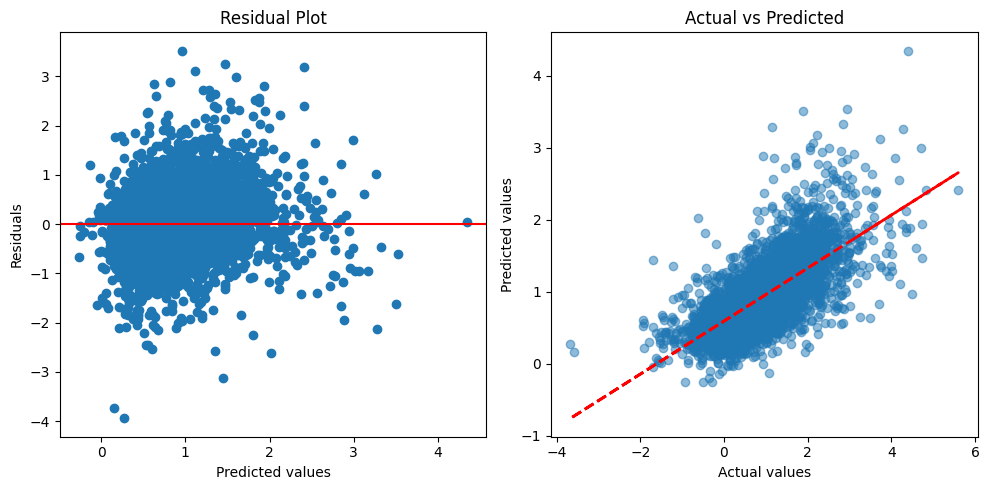

                                     Value
Mean Absolute Error (MAE)           0.4615
Mean Squared Error (MSE)            0.3873
Root Mean Squared Error (RMSE)      0.6223
R-squared                           0.4510
Adjusted R-squared                  0.4317
Durbin-Watson                       2.0115
Shapiro-Wilk Statistic              0.9732
Shapiro-Wilk p-value                0.0000
AIC                             10639.9294
BIC                             11861.0772
RandomForestRegressor
y_test_df.shape:(5436, 1)
y_hat_df.shape:(5436, 1)


p-value may not be accurate for N > 5000.


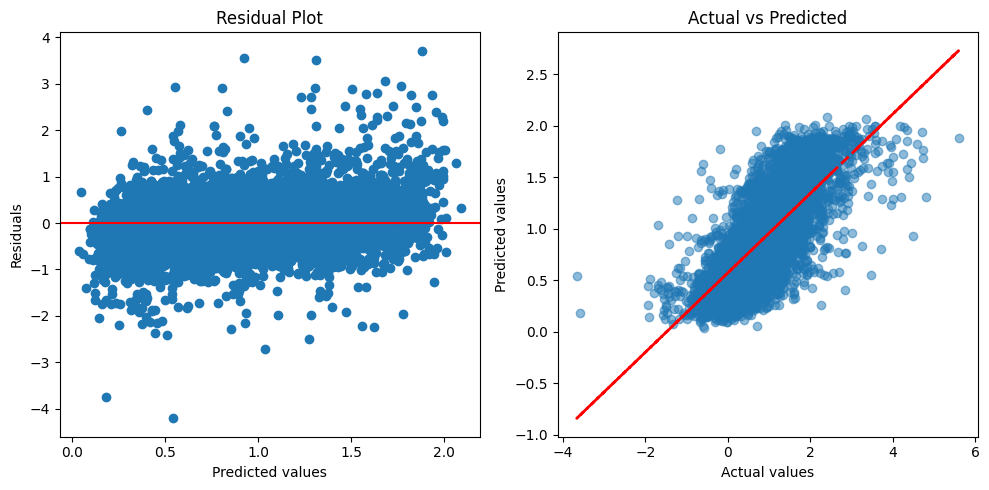

                                     Value
Mean Absolute Error (MAE)           0.4387
Mean Squared Error (MSE)            0.3609
Root Mean Squared Error (RMSE)      0.6008
R-squared                           0.4884
Adjusted R-squared                  0.4704
Durbin-Watson                       2.0113
Shapiro-Wilk Statistic              0.9628
Shapiro-Wilk p-value                0.0000
AIC                             10256.1472
BIC                             11477.2950
XGBRegressor
y_test_df.shape:(5436, 1)
y_hat_df.shape:(5436, 1)


p-value may not be accurate for N > 5000.


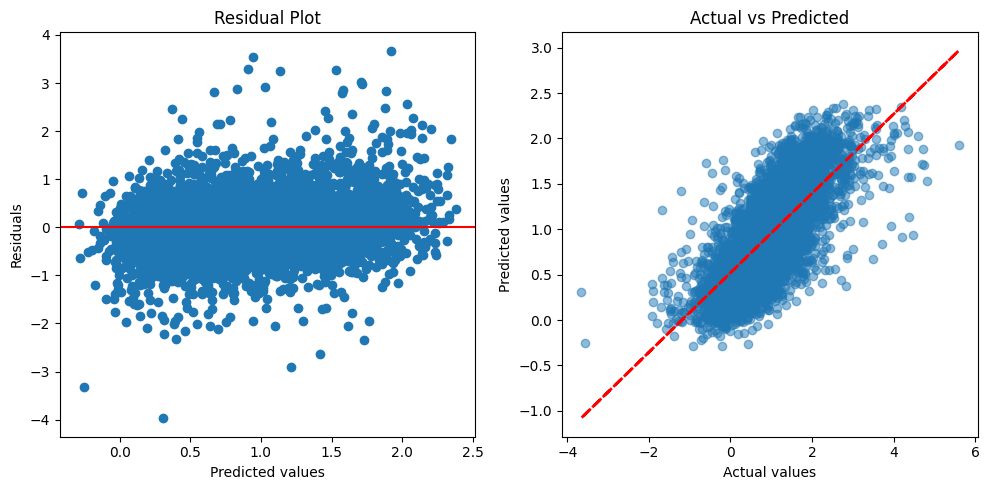

                                     Value
Mean Absolute Error (MAE)           0.4290
Mean Squared Error (MSE)            0.3414
Root Mean Squared Error (RMSE)      0.5843
R-squared                           0.5161
Adjusted R-squared                  0.4990
Durbin-Watson                       2.0153
Shapiro-Wilk Statistic              0.9644
Shapiro-Wilk p-value                0.0000
AIC                              9953.2548
BIC                             11174.4026
Model: KNeighborsRegressor
Accuracy: 0.9639
Confusion Matrix:
[[5240    0]
 [ 196    0]]
KNeighborsRegressor
y_test_df.shape:(5436, 1)
y_hat_df.shape:(5436, 1)


p-value may not be accurate for N > 5000.


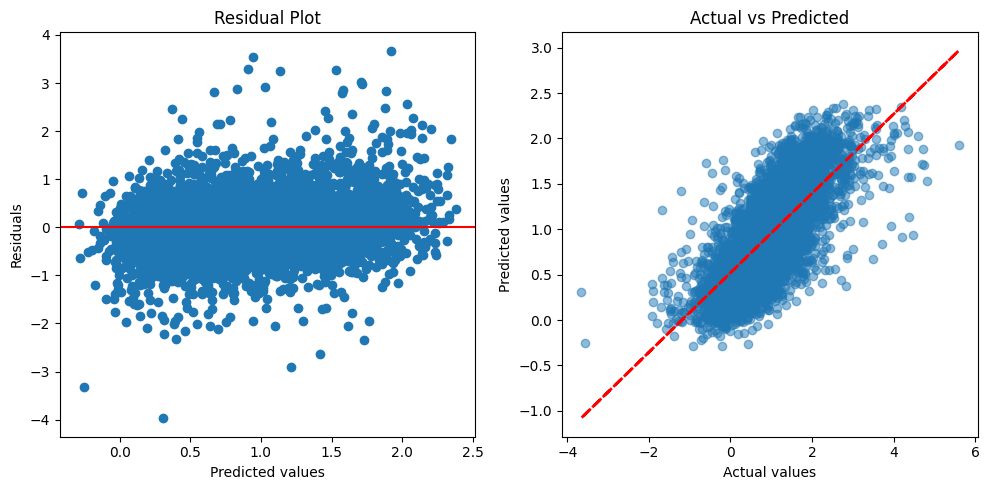

                                     Value
Mean Absolute Error (MAE)           0.4290
Mean Squared Error (MSE)            0.3414
Root Mean Squared Error (RMSE)      0.5843
R-squared                           0.5161
Adjusted R-squared                  0.4990
Durbin-Watson                       2.0153
Shapiro-Wilk Statistic              0.9644
Shapiro-Wilk p-value                0.0000
AIC                              9953.2548
BIC                             11174.4026
Model: KNeighborsRegressor
Accuracy: 0.9639
Confusion Matrix:
[[5240    0]
 [ 196    0]]
KNeighborsRegressor
y_test_df.shape:(5436, 1)
y_hat_df.shape:(5436, 1)


p-value may not be accurate for N > 5000.


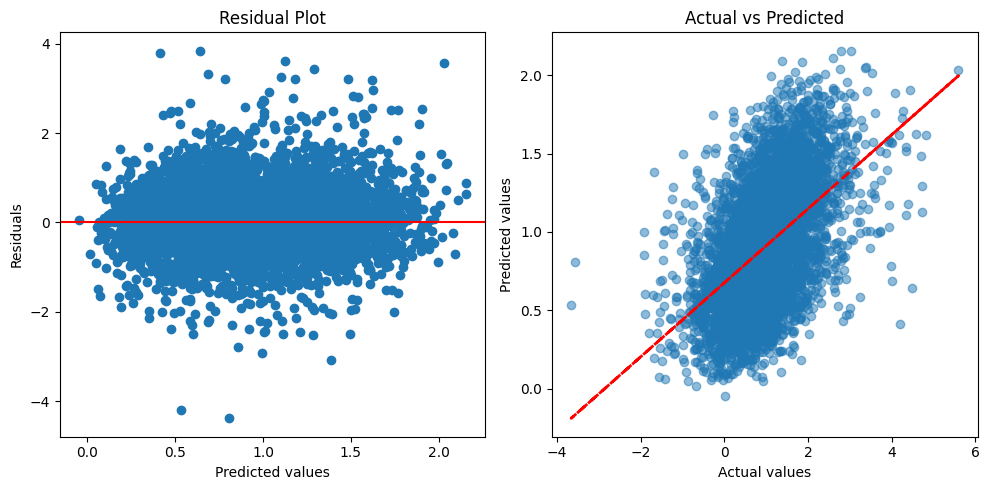

                                     Value
Mean Absolute Error (MAE)           0.5414
Mean Squared Error (MSE)            0.5176
Root Mean Squared Error (RMSE)      0.7195
R-squared                           0.2663
Adjusted R-squared                  0.2404
Durbin-Watson                       2.0167
Shapiro-Wilk Statistic              0.9795
Shapiro-Wilk p-value                0.0000
AIC                             12196.8124
BIC                             13417.9601
Iteration 1, loss = 0.25325896
Validation score: 0.260663
Iteration 2, loss = 0.11998150
Validation score: 0.339553
Iteration 3, loss = 0.10736222
Validation score: 0.350637
Iteration 4, loss = 0.09985307
Validation score: 0.383535
Iteration 5, loss = 0.09471371
Validation score: 0.393210
Iteration 6, loss = 0.09107875
Validation score: 0.400039
Iteration 7, loss = 0.08732889
Validation score: 0.405664
Iteration 8, loss = 0.08448589
Validation score: 0.392667
Iteration 9, loss = 0.08294229
Validation score: 0.390894
Itera

p-value may not be accurate for N > 5000.


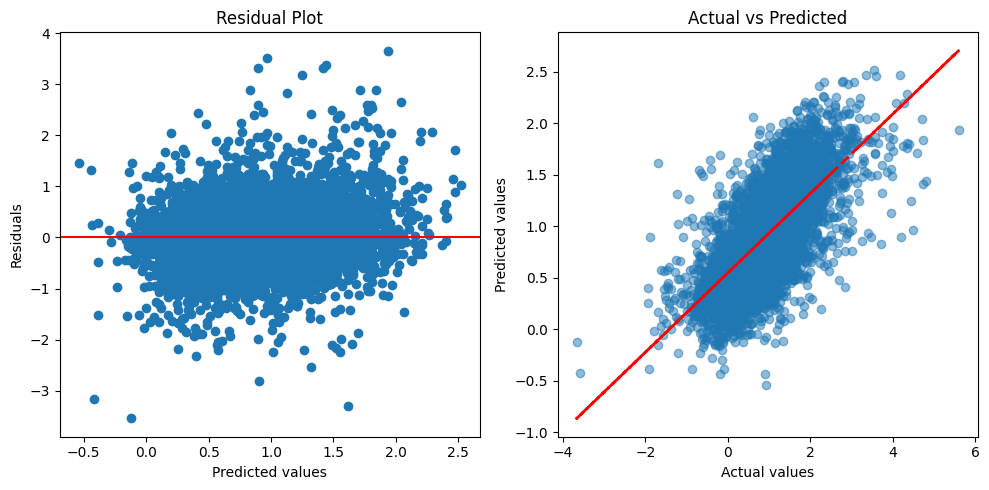

                                     Value
Mean Absolute Error (MAE)           0.4580
Mean Squared Error (MSE)            0.3832
Root Mean Squared Error (RMSE)      0.6190
R-squared                           0.4568
Adjusted R-squared                  0.4377
Durbin-Watson                       2.0043
Shapiro-Wilk Statistic              0.9710
Shapiro-Wilk p-value                0.0000
AIC                             10569.6566
BIC                             11790.8044
Iteration 1, loss = 0.67521437
Validation score: -1.367020
Iteration 2, loss = 0.31907590
Validation score: -0.279774
Iteration 3, loss = 0.18176846
Validation score: 0.117736
Iteration 4, loss = 0.13974588
Validation score: 0.227437
Iteration 5, loss = 0.12619410
Validation score: 0.265063
Iteration 6, loss = 0.11951464
Validation score: 0.298680
Iteration 7, loss = 0.11364676
Validation score: 0.312341
Iteration 8, loss = 0.10979746
Validation score: 0.332084
Iteration 9, loss = 0.10656287
Validation score: 0.337008
Ite

p-value may not be accurate for N > 5000.


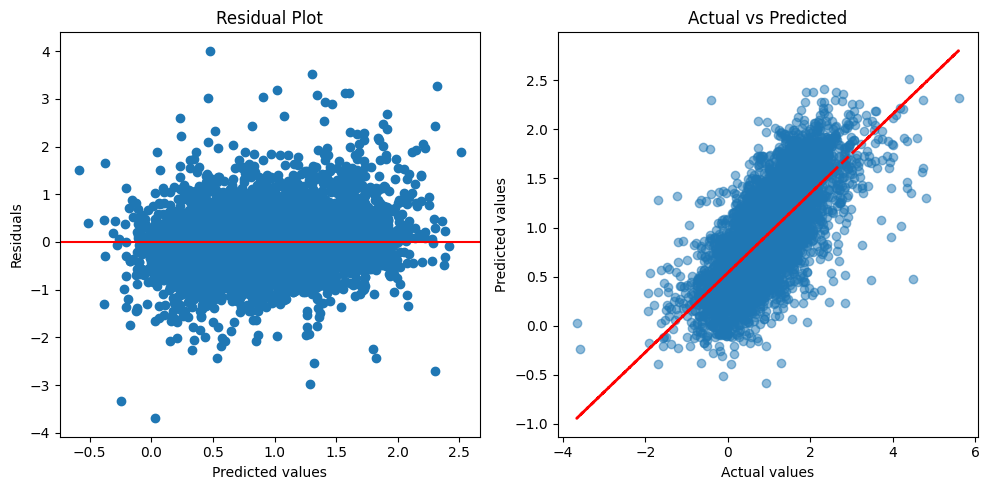

                                     Value
Mean Absolute Error (MAE)           0.4471
Mean Squared Error (MSE)            0.3656
Root Mean Squared Error (RMSE)      0.6047
R-squared                           0.4817
Adjusted R-squared                  0.4635
Durbin-Watson                       2.0115
Shapiro-Wilk Statistic              0.9688
Shapiro-Wilk p-value                0.0000
AIC                             10319.9767
BIC                             11541.1244


In [ ]:
#=================================================================
# TEST DIFFERENT MODELS USING A REGRESSION APPROACH, THEN A CLASSIFICATION APPROACH - FPG
#=================================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import math
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm

# Load data
directory = 'THE_FINAL_MASTER_DATASET(-16,-XHOMA,-33.3,-60%_0,-FPI)2.csv'
df = pd.read_csv(directory, low_memory=False)

# Drop row 21396
#df.drop(21396, inplace=True)  # This drops the row by its index
#df.drop(18506, inplace=True)
#df.drop(22597, inplace=True)
#df.drop( 26446, inplace=True)

# Set 'seqn' as the index
df.set_index('seqn', inplace=True)

# Convert object columns to numeric categories
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.factorize(df[col])[0]

# Split data
y = df['homa-ir']
X = df.drop(columns=['homa-ir'])

test_type = 3
X_train, y_train, X_test, y_test = preprocess(X, y)

models = ["stepwise_regression", "RandomForestRegressor", "XGBRegressor", "KNeighborsRegressor", "MLPRegressor", "MLPRegressor_simple"]
#models = ["stepwise_regression"]

for mod in models:
  if mod == "stepwise_regression":
    mod, selected_col_nos = stepwise_regression(X_train, y_train, X_test, y_test, 10)
    y_hat = predict_with_selected_model(X_test[:, selected_col_nos], mod)
  elif mod == 'RandomForestRegressor':
    # Train Random Forest Regressor
    regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    regressor.fit(X_train, y_train)
    y_hat = regressor.predict(X_test)
  elif mod == "XGBRegressor":
    xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    xgb_regressor.fit(X_train, y_train)
    y_hat = xgb_regressor.predict(X_test)
  elif mod == "KNeighborsRegressor":
    # Step 1: Scaling the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)  # If you have a test set and you want to scale it

    # Step 2: Applying KNN regression
    k = 5  # You can choose any value for k, but 5 is a common starting point
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    knn_regressor.fit(X_train_scaled, y_train)





# Convert regression predictions to classification values
    y_hat_classified = np.where(y_hat > 2.5, 1, 0)  # 1 for >2.5, 0 for <=2.5

    # Convert actual y_test values to classification values
    y_test_classified = np.where(y_test > 2.5, 1, 0)

    # Evaluation
    from sklearn.metrics import accuracy_score, confusion_matrix

    accuracy = accuracy_score(y_test_classified, y_hat_classified)
    cm = confusion_matrix(y_test_classified, y_hat_classified)

    print(f"Model: {mod}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    # Continue with regression results
    n_features = X_train.shape[1]

    print(mod)
    y_test_df = pd.DataFrame(y_test, columns=["y_test"])
    y_hat_df = pd.DataFrame(y_hat, columns=["y_hat"])

    print("y_test_df.shape:" + str(y_test_df.shape))
    print("y_hat_df.shape:" + str(y_hat_df.shape))

    summary = model_evaluation(y_test_df, y_hat_df, n_features)
    print(summary)



    # Convert regression predictions to classification values
    y_hat_classified = np.where(y_hat > 2.5, 1, 0)  # 1 for >2.5, 0 for <=2.5

    # Convert actual y_test values to classification values
    y_test_classified = np.where(y_test > 2.5, 1, 0)

    # Evaluation
    from sklearn.metrics import accuracy_score, confusion_matrix

    accuracy = accuracy_score(y_test_classified, y_hat_classified)
    cm = confusion_matrix(y_test_classified, y_hat_classified)

    print(f"Model: {mod}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Confusion Matrix:\n{cm}")







    # Predicting on the training set (or on a test set if you have one)
    y_hat = knn_regressor.predict(X_test_scaled)

  elif mod == "MLPRegressor":
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)


    # Initializing the MLP regressor
    mlp_regressor = MLPRegressor(hidden_layer_sizes=(50, 30),  # 2 hidden layers: 50 neurons in the first layer, 30 in the second
                                activation='tanh',           # Activation function
                                solver='adam',               # Optimization algorithm
                                max_iter=1000,               # Maximum iterations (epochs)
                                early_stopping=True,         # Stop training when validation score is not improving
                                validation_fraction=0.1,     # 10% of training data will be used as validation
                                verbose=True)                # Print progress

    # Fit the regressor
    mlp_regressor.fit(X_train_scaled, y_train)

    # Predicting on the training set
    y_hat = mlp_regressor.predict(X_test_scaled)
  elif mod == "MLPRegressor_simple":
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)


    # Initializing the MLP regressor
    mlp_regressor = MLPRegressor(hidden_layer_sizes=(10),  # 2 hidden layers: 50 neurons in the first layer, 30 in the second
                                activation='tanh',           # Activation function
                                solver='adam',               # Optimization algorithm
                                max_iter=1000,               # Maximum iterations (epochs)
                                early_stopping=True,         # Stop training when validation score is not improving
                                validation_fraction=0.1,     # 10% of training data will be used as validation
                                verbose=True)                # Print progress

    # Fit the regressor
    mlp_regressor.fit(X_train_scaled, y_train)



    # Predicting on the training set
    y_hat = mlp_regressor.predict(X_test_scaled)
  else:
    raise ("MOD TYPE NOT FOUND")
  n_features = X_train.shape[1]

  print(mod)
  y_test_df = pd.DataFrame(y_test, columns=["y_test"])
  y_hat_df = pd.DataFrame(y_hat, columns=["y_hat"])

  print("y_test_df.shape:" + str(y_test_df.shape))
  print("y_hat_df.shape:" + str(y_hat_df.shape))

  summary = model_evaluation(y_test_df, y_hat_df, n_features)
  print(summary)
